## IOI with DAS

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/Indirect%20object%20identification%20(IOI)%20circuit%20with%20DAS.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "12/31/2023"

### Overview

This tutorial aims to replicate key findings from previous mechanistic interpretability papers that examine the IOI task using this library. It focuses on identifying alignments for the name position information and the output IO name at various locations within the neural networks.

Additionally, the tutorial seeks to provide new insights into GPT-2's causal mechanisms in solving this task by analyzing how information is stored and processed across different attention heads.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [3]:
import random
import pandas as pd
from tutorial_ioi_utils import *
from pyvene import embed_to_distrib, top_vals, format_token, sigmoid_boundary
from pyvene import (
    IntervenableModel,
    RepresentationConfig,
    IntervenableConfig,
    LowRankRotatedSpaceIntervention,
    SkipIntervention,
    VanillaIntervention,
    BoundlessRotatedSpaceIntervention,
)
from pyvene import create_gpt2_lm

import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    scale_y_reverse,
    scale_fill_cmap,
    geom_text,
    scale_fill_gradient,
    geom_point,
    geom_line,
    theme_minimal,
    ylim,
    ggtitle,
    ggsave,
    labs,
    scale_x_discrete,
    geom_histogram,
    scale_fill_manual,
)

# please try not to do this, the plot somehow throw warnings though :(
import warnings

warnings.filterwarnings("ignore")

config, tokenizer, gpt2 = create_gpt2_lm()
_ = gpt2.eval().to("cuda" if torch.cuda.is_available() else "cpu")

loaded model


### Factual recall
We first check IOI task performance of GPT-2.

In [4]:
transformers.set_seed(42)
tokenizer.pad_token = tokenizer.eos_token

def get_last_token(logits, attention_mask):
    last_token_indices = attention_mask.sum(1) - 1
    batch_indices = torch.arange(logits.size(0)).unsqueeze(1)
    return logits[batch_indices, last_token_indices.unsqueeze(1)].squeeze(1)

train_distribution = PromptDistribution(
    names=NAMES[: len(NAMES) // 2],
    objects=OBJECTS[: len(OBJECTS) // 2],
    places=PLACES[: len(PLACES) // 2],
    templates=TEMPLATES_PATH,
)

D_train = train_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=["ABB", "BAB"],
    source_patterns=["ABB", "BAB"],
    labels="position",
    samples_per_combination=50,
)

total_count = 0
correct_count = 0
with torch.no_grad():
    for batch_dataset in D_train.batches(batch_size=30):
        inputs = batch_dataset.base.tokens

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(gpt2.device)
        labels = batch_dataset.base.answer_tokens[:, 0].to(gpt2.device)

        outputs = gpt2(**inputs)
        logits = get_last_token(outputs.logits, inputs["attention_mask"]).unsqueeze(1)

        pred_labels = logits.argmax(dim=-1)[:, -1]
        correct_labels = labels == pred_labels

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
current_acc = round(correct_count / total_count, 2)
print(f"gpt-2 IOI task accuracy: {current_acc}")

gpt-2 IOI task accuracy: 0.91


### Localizing the name position information in the main residual stream and MLP activations
This section reproduces main results in [this paper](https://arxiv.org/pdf/2311.17030.pdf). To address the IOI task, previous studies have shown that GPT-2 creates representations for a causal variable representing the correct name position (either the first or second name mentioned in a sentence). Our objective is to utilize our library to pinpoint the location of name position information at each layer and across several positions, not just at the last token position.

In [5]:
block_out_data = find_variable_at(
    gpt2,
    tokenizer,
    positions=[13, 14, 15, 16, 17],
    layers=[i for i in range(12)],
    stream="block_output",
    aligning_variable="position",
    debug=True,
)

finding name position at: pos->13, layers->0, stream->block_output


AssertionError: 

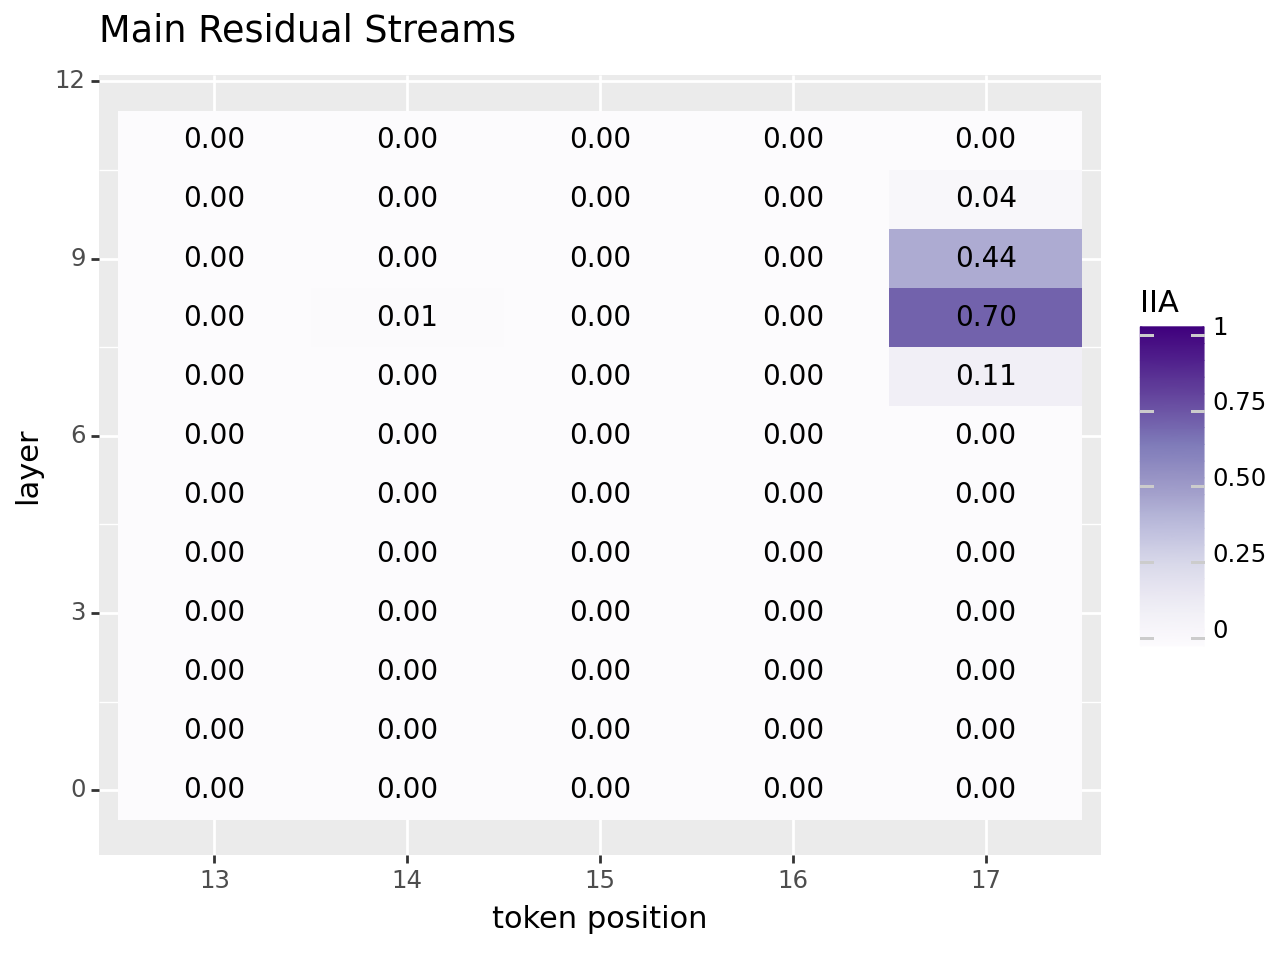

<Figure Size: (640 x 480)>

In [6]:
# these lines are comment out since we have run the experiments.
# df = pd.DataFrame(block_out_data)
# df.to_csv("./tutorial_data/block_out_df.csv")
df = pd.read_csv("./tutorial_data/block_out_df.csv")
df["layer"] = df["layer"].astype(int)
df["token position"] = df["pos"].astype(int)
df["IIA"] = df["acc"].astype(float)
df["token position"] = df["token position"].astype("category")

# Use format string to keep two decimal places
df["IIA_label"] = df["IIA"].apply(lambda x: f"{x:.2f}")

block_out_plot = (
    ggplot(df, aes(x="token position", y="layer"))
    + geom_tile(aes(fill="IIA"))
    + scale_fill_cmap("Purples", limits=[0, 1])
    + geom_text(aes(label="IIA_label"), color="black", size=10)
    + ggtitle("Main Residual Streams")
)
ggsave(block_out_plot, filename="./tutorial_data/block_out_plot.pdf", dpi=200)
block_out_plot

In [ ]:
mlp_activation_data = find_variable_at(
    gpt2,
    tokenizer,
    positions=[13, 14, 15, 16, 17],
    layers=[i for i in range(12)],
    stream="mlp_activation",
    aligning_variable="position",
    debug=True,
)

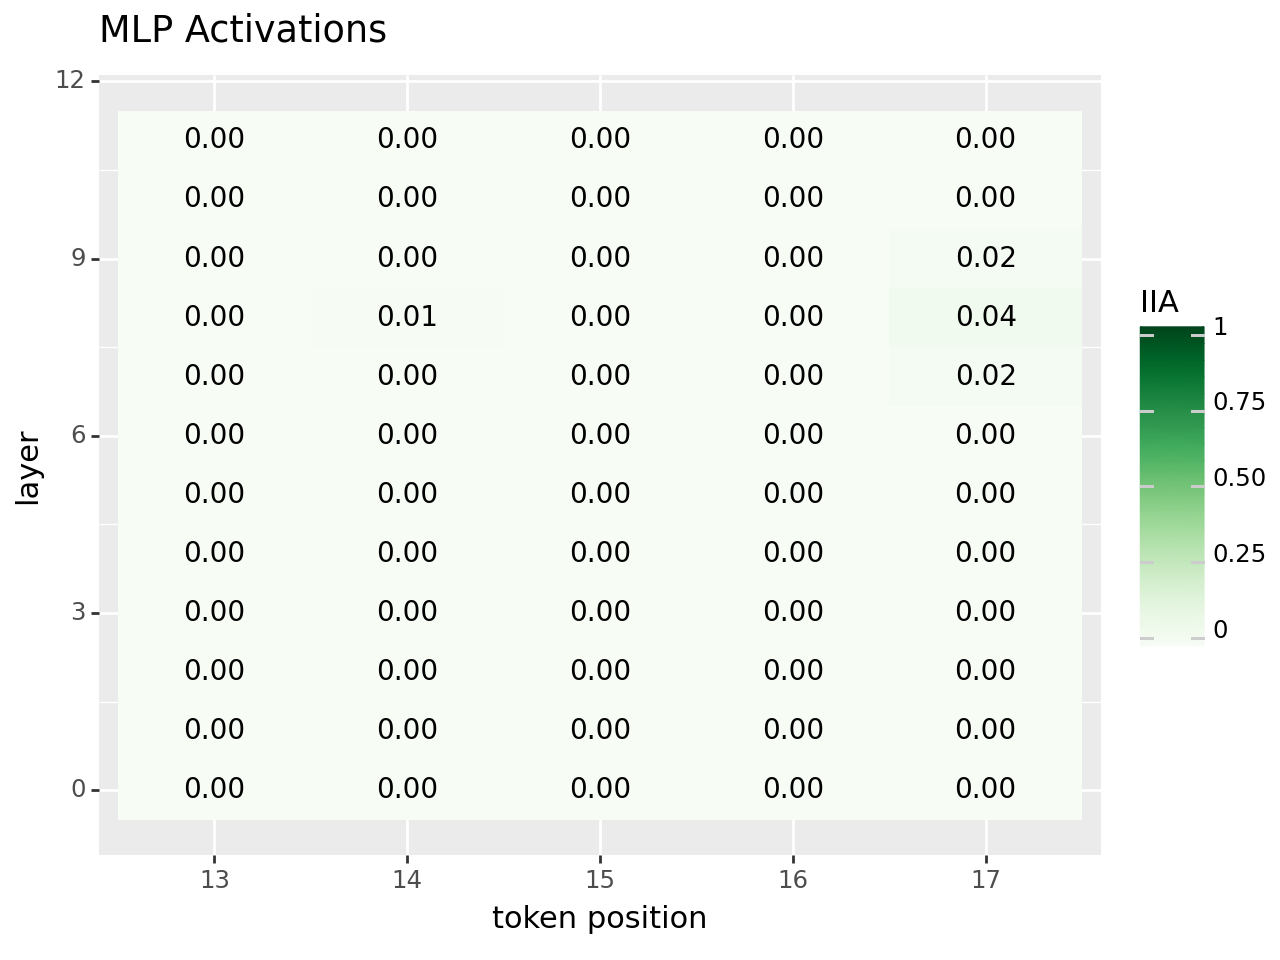

<Figure Size: (640 x 480)>

In [7]:
# df = pd.DataFrame(mlp_activation_data)
# df.to_csv("./tutorial_data/mlp_activation_df.csv")
df = pd.read_csv("./tutorial_data/mlp_activation_df.csv")
df["layer"] = df["layer"].astype(int)
df["token position"] = df["pos"].astype(int)
df["IIA"] = df["acc"].astype(float)
df["token position"] = df["token position"].astype("category")

# Use format string to keep two decimal places
df["IIA_label"] = df["IIA"].apply(lambda x: f"{x:.2f}")

mlp_activaiton_plot = (
    ggplot(df, aes(x="token position", y="layer"))
    + geom_tile(aes(fill="IIA"))
    + scale_fill_cmap("Greens", limits=[0, 1])
    + geom_text(aes(label="IIA_label"), color="black", size=10)
    + ggtitle("MLP Activations")
)
ggsave(mlp_activaiton_plot, filename="./tutorial_data/mlp_activaiton_plot.pdf", dpi=200)
mlp_activaiton_plot

### Localizing in across multiple tokens at layer 7, one layer earlier than layer 8

In [ ]:
block_out_across_tokens_data = find_variable_at(
    gpt2,
    tokenizer,
    [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]],
    [7],
    "block_output",
    aligning_variable="position",
    debug=True,
)

### Localizing in different streams

In [ ]:
attn_input_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "attention_input", debug=True
)
block_input_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "block_input", debug=True
)
mlp_input_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "mlp_input", debug=True
)
mlp_act_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "mlp_activation", debug=True
)
attn_out_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "attention_output", debug=True
)
mlp_out_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "mlp_output", debug=True
)
attn_value_out_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "attention_value_output", debug=True
)
block_output_data = find_variable_at(
    gpt2, tokenizer, [17], [i for i in range(12)], "block_output", debug=True
)

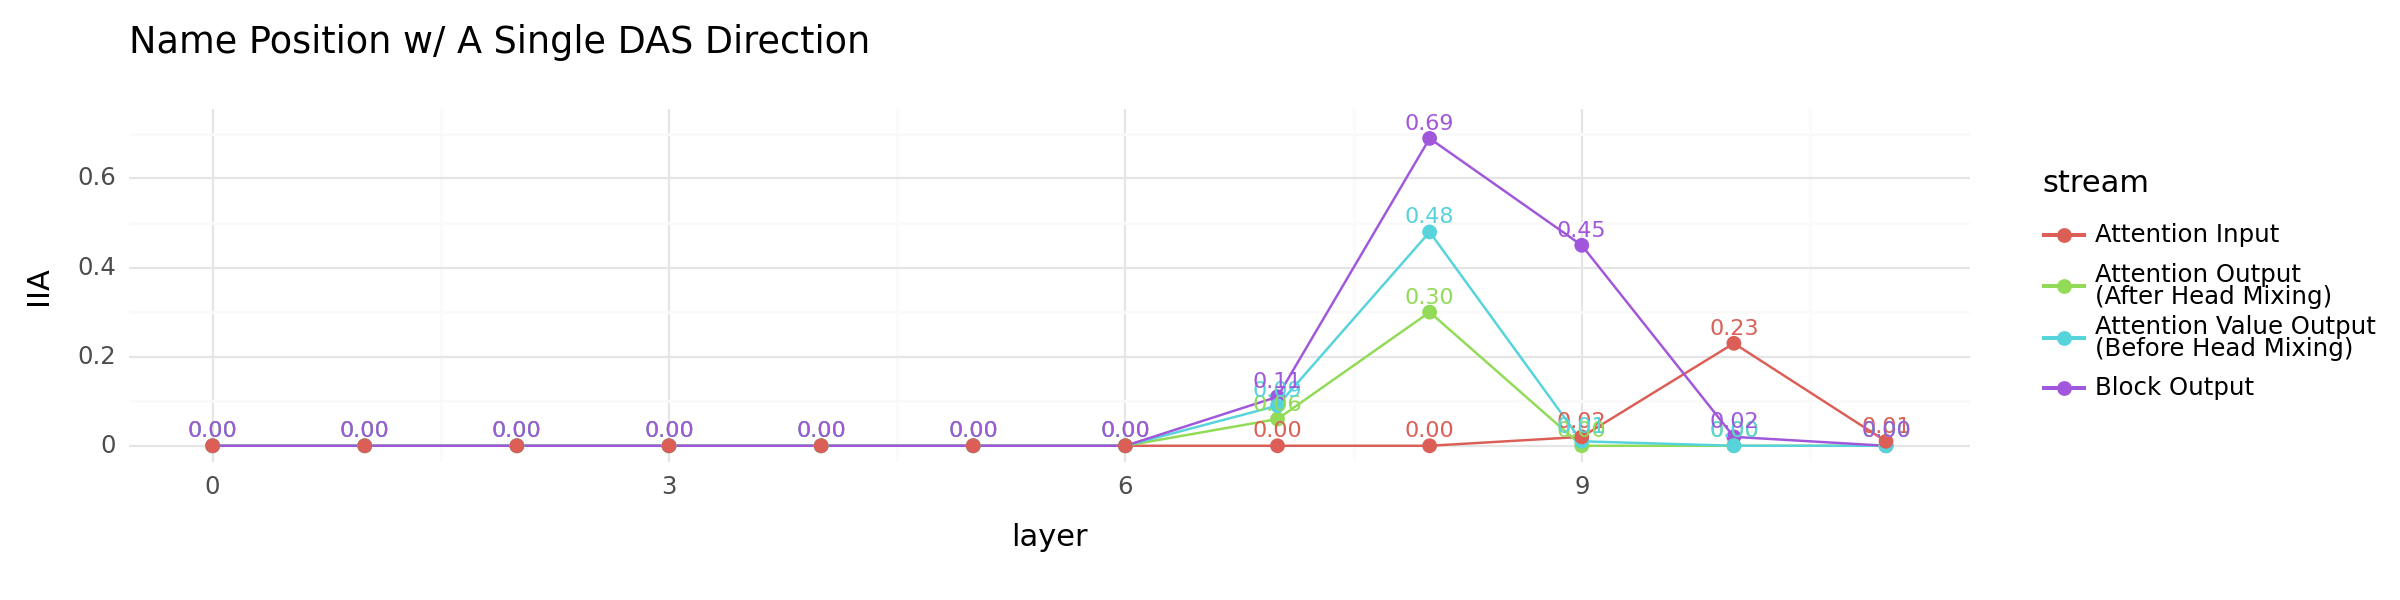

<Figure Size: (1200 x 300)>

In [10]:
all_streams_df = pd.read_csv("./tutorial_data/all_streams_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin(
        {
            "block_output",
            "attention_input",
            "attention_output",
            "attention_value_output",
        }
    )
].copy()
stream_labels = {
    "block_output": "Block Output",
    "attention_input": "Attention Input",
    "attention_output": "Attention Output\n(After Head Mixing)",
    "attention_value_output": "Attention Value Output\n(Before Head Mixing)",
}
df.loc[:, "stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df.loc[:, "IIA_formatted"] = df["IIA"].map(custom_format)
other_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Name Position w/ A Single DAS Direction")
)

ggsave(
    other_locations_plot, filename="./tutorial_data/other_locations_plot.pdf", dpi=200
)
other_locations_plot

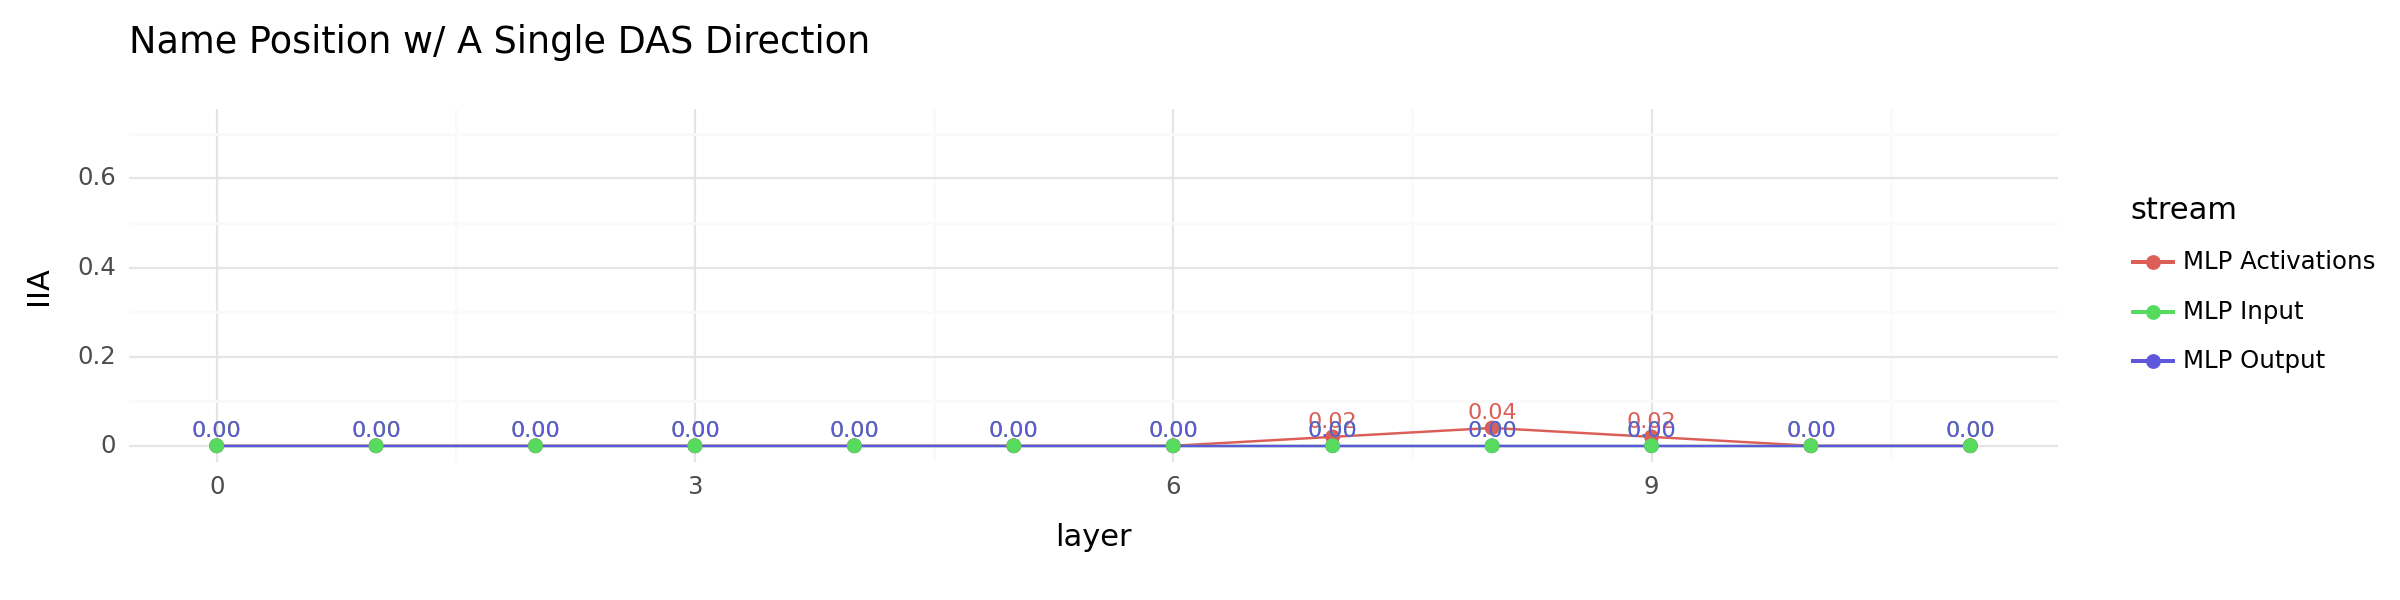

<Figure Size: (1200 x 300)>

In [9]:
# all_streams_df = pd.DataFrame(
#     block_output_data+attn_out_data+
#     mlp_out_data+attn_value_out_data+
#     mlp_act_data+mlp_input_data+
#     block_input_data+attn_input_data
# )
# all_streams_df.to_csv("./tutorial_data/all_streams_df.csv")
all_streams_df = pd.read_csv("./tutorial_data/all_streams_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin({"mlp_output", "mlp_input", "mlp_activation"})
].copy()
stream_labels = {
    "mlp_output": "MLP Output",
    "mlp_input": "MLP Input",
    "mlp_activation": "MLP Activations",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
all_mlp_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Name Position w/ A Single DAS Direction")
)

ggsave(
    all_mlp_locations_plot,
    filename="./tutorial_data/all_mlp_locations_plot.pdf",
    dpi=200,
)
all_mlp_locations_plot

### Localizing in each individual head at layer 7 and 8
We further investigate whether any heads in the 7th and 8th layers specialize in name position information. Note that we consider each head individually in this analysis. Therefore, if the name position information is distributed across tokens, it would not be detectable in this context.

In [ ]:
head_attn_value_out_data = []
for h in range(12):
    _head_attn_value_out_data = find_variable_at(
        gpt2, tokenizer, [17], [7, 8], "head_attention_value_output", [h]
    )
    head_attn_value_out_data.extend(_head_attn_value_out_data)

In [ ]:
df = pd.DataFrame(head_attn_value_out_data)

plot = (
    ggplot(df, aes(x="layer", y="acc", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + theme_minimal()
    + ylim(0, 1)
)

print(plot)

### Localizing with group of heads using rankings of missing out head IIA
When examining each individual head, localizing the name position information was not possible. Why is this? The information is likely distributed across multiple heads. To further investigate, let's perform an additional check by localizing in the concatenated head representations, leaving only one head out at a time. We leave one head out to determine if omitting specific heads results in significant drops in IIA.

In [ ]:
layer = 7

head_attn_value_out_mo_data = []
for i in range(12):
    print("evaluating grouped IIA without head", i)
    _head_attn_value_out_mo_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_attention_value_output",
        heads=list(set([i for i in range(12)]) - {i}),
    )[0]
    _head_attn_value_out_mo_data["mo_head"] = i
    head_attn_value_out_mo_data += [_head_attn_value_out_mo_data]

In [ ]:
head_rank_list = []
anchor_acc = 0.48
for data in head_attn_value_out_mo_data:
    head_rank_list += [(data["mo_head"], anchor_acc - data["acc"])]
head_rank_list = sorted(head_rank_list, key=lambda x: x[1], reverse=True)

In [ ]:
df = pd.DataFrame(head_attn_value_out_mo_data)
df["mo_head_cat"] = pd.Categorical(
    df["mo_head"], categories=df["mo_head"].unique(), ordered=True
)
head_drop_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Leave-One-Out (LOO) Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"head {i}" for i in df["mo_head"]])
)

ggsave(
    head_drop_plot,
    filename=f"./tutorial_data/layer_{layer}_head_drop_plot.pdf",
    dpi=200,
)
head_drop_plot

In [ ]:
head_attn_value_out_cumulative_data = []
current_heads = []
for i in head_rank_list:
    current_heads += [i[0]]
    print("evaluating grouped IIA adding head", i[0])
    _head_attn_value_out_cumulative_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_attention_value_output",
        heads=current_heads,
    )[0]
    _head_attn_value_out_cumulative_data["adding_head"] = i[0]
    head_attn_value_out_cumulative_data += [_head_attn_value_out_cumulative_data]

In [ ]:
df = pd.DataFrame(head_attn_value_out_cumulative_data)
df["adding_head_cat"] = pd.Categorical(
    df["adding_head"], categories=df["adding_head"].unique(), ordered=True
)

head_acc_plot = (
    ggplot(df, aes(x="adding_head_cat", y="acc", fill="adding_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Cumulative Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"+ head {i}" for i in df["adding_head"]])
)

ggsave(
    head_acc_plot, filename=f"./tutorial_data/layer_{layer}_head_acc_plot.pdf", dpi=200
)
head_acc_plot

### Localizing the correct IO name with vanilla causal abstraction (no training)
We can further localize the correct IO name in the output streams. We use vanilla interchange intervention, so there is no training just activation swap.

In [11]:
attn_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_input",
    aligning_variable="name",  # now we are localizing the IO name
    do_vanilla_intervention=True,  # we avoid learning DAS for this since outspace is large here.
    debug=False,
)
block_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_input",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)
mlp_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_input",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)
mlp_act_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_activation",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)
attn_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_output",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)
mlp_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_output",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)
attn_value_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_value_output",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)
block_output_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_output",
    aligning_variable="name",
    do_vanilla_intervention=True,
    debug=False,
)

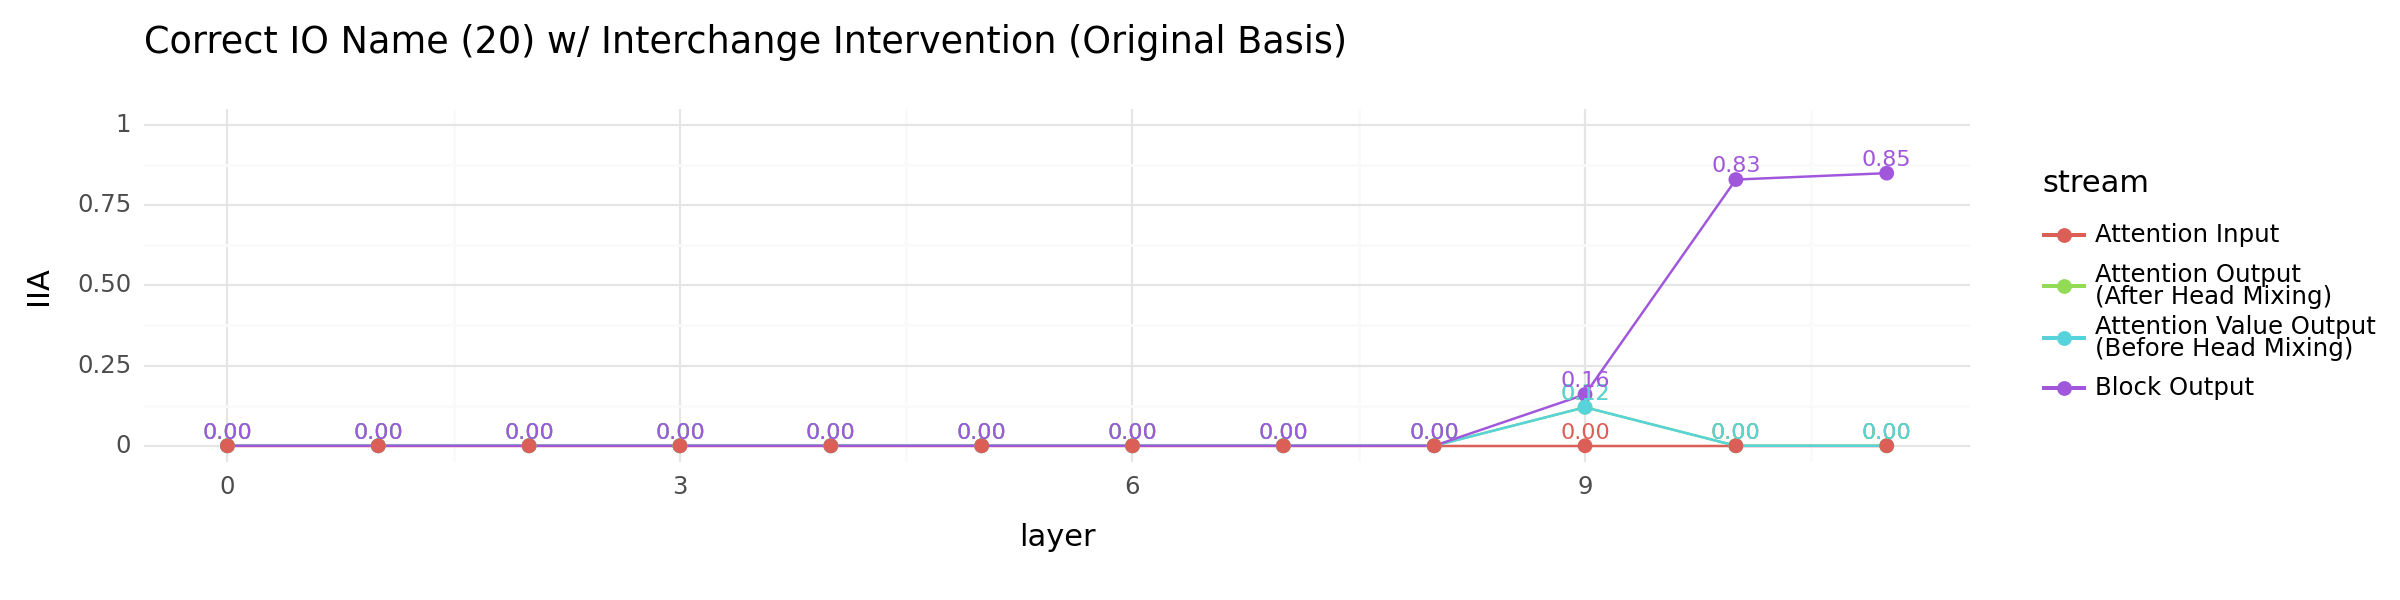

<Figure Size: (1200 x 300)>

In [12]:
all_streams_df = pd.DataFrame(
    block_output_data
    + attn_out_data
    + mlp_out_data
    + attn_value_out_data
    + mlp_act_data
    + mlp_input_data
    + block_input_data
    + attn_input_data
)
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin(
        {
            "block_output",
            "attention_input",
            "attention_output",
            "attention_value_output",
        }
    )
].copy()
stream_labels = {
    "block_output": "Block Output",
    "attention_input": "Attention Input",
    "attention_output": "Attention Output\n(After Head Mixing)",
    "attention_value_output": "Attention Value Output\n(Before Head Mixing)",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
other_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 1)
    + theme(figure_size=(12, 3))
    + ggtitle("Correct IO Name (20) w/ Interchange Intervention (Original Basis)")
)
ggsave(
    other_locations_plot,
    filename="./tutorial_data/IO_name_other_locations_plot.pdf",
    dpi=200,
)
other_locations_plot

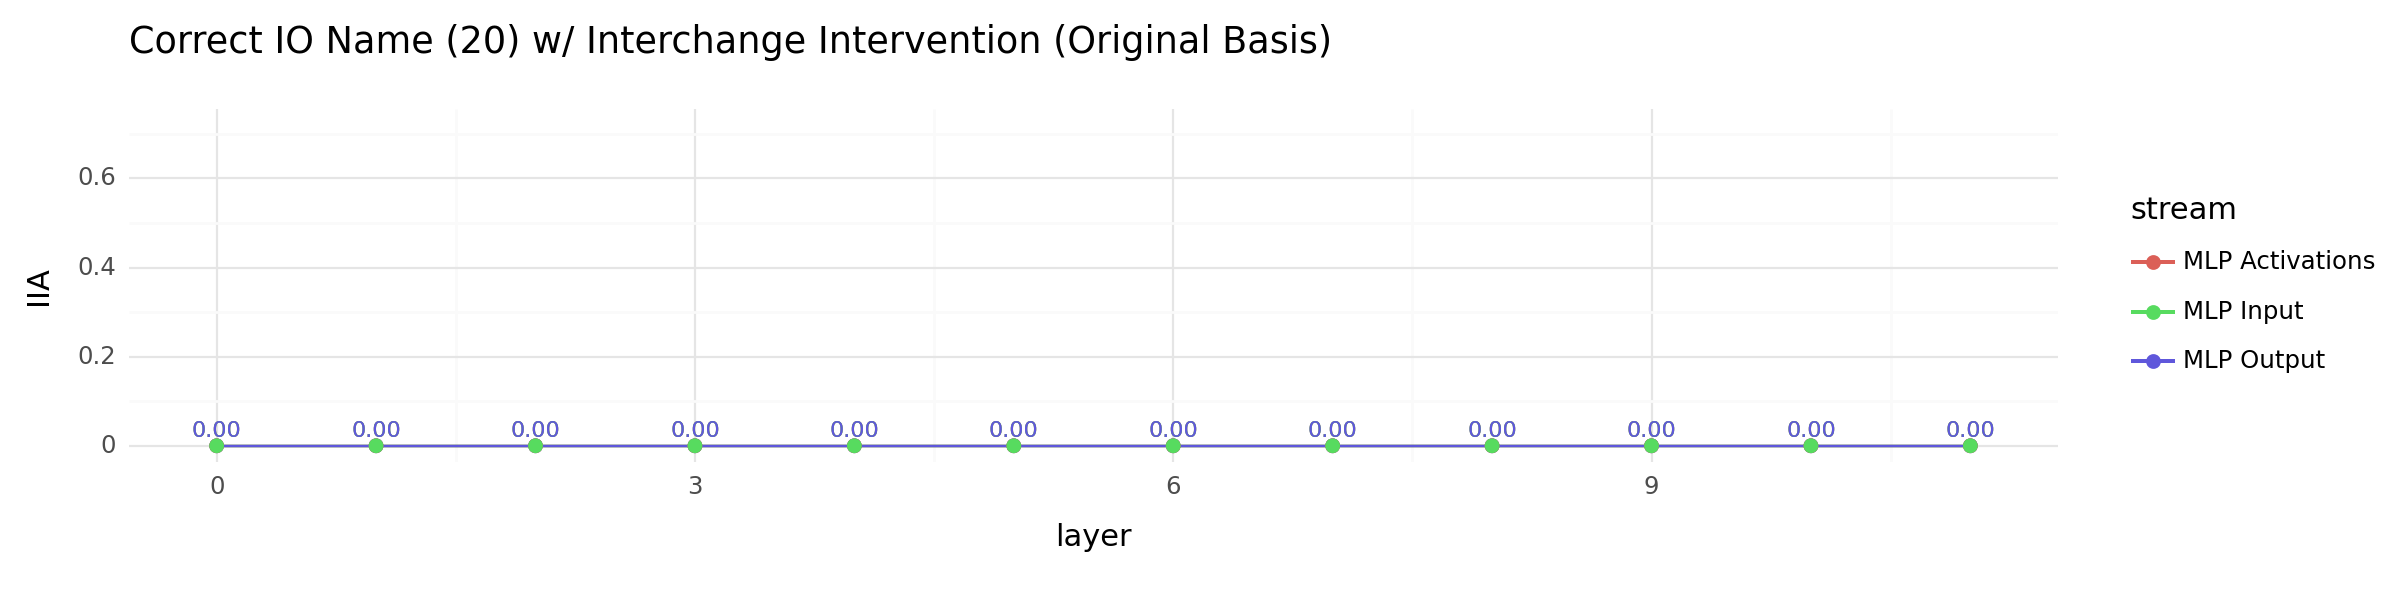

<Figure Size: (1200 x 300)>

In [13]:
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin({"mlp_output", "mlp_input", "mlp_activation"})
]
stream_labels = {
    "mlp_output": "MLP Output",
    "mlp_input": "MLP Input",
    "mlp_activation": "MLP Activations",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
all_mlp_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Correct IO Name (20) w/ Interchange Intervention (Original Basis)")
)
ggsave(
    all_mlp_locations_plot,
    filename="./tutorial_data/IO_name_all_mlp_locations_plot.pdf",
    dpi=200,
)
all_mlp_locations_plot

### Localizing the correct IO name with DAS (20 names only with 20 dimension DAS)
We now localize the IO name with DAS. To make things easier, we restrict the dataset to contain 20 distinct names. Training and evaluation share the same set of names. We use a fixed dimension size of 20 for DAS training. Everything else is kept the same as previous experiments.

In [ ]:
attn_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_input",
    low_rank_dimension=20,
    aligning_variable="name",  # now we are localizing the IO name
    debug=False,
)
block_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_input",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)
mlp_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_input",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)
mlp_act_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_activation",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)
attn_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_output",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)
mlp_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_output",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)
attn_value_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_value_output",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)
block_output_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_output",
    low_rank_dimension=20,
    aligning_variable="name",
    debug=False,
)

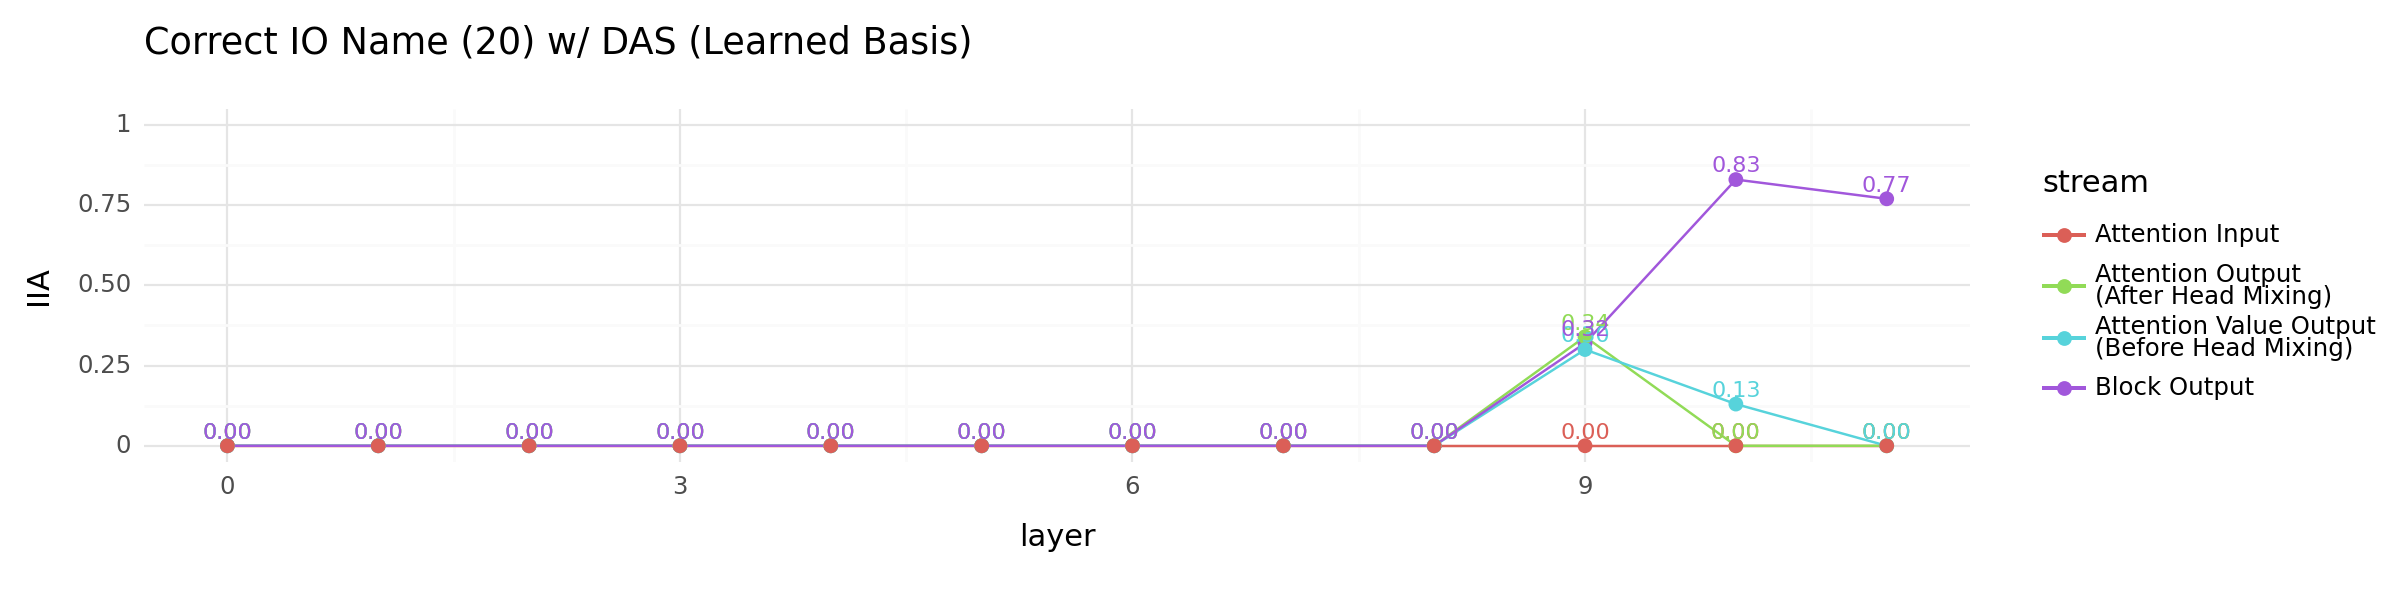

<Figure Size: (1200 x 300)>

In [14]:
# all_streams_io_name_df = pd.DataFrame(
#     block_output_data+
#     attn_out_data+mlp_out_data+
#     attn_value_out_data+mlp_act_data+
#     mlp_input_data+block_input_data+attn_input_data
# )
# all_streams_io_name_df.to_csv("./tutorial_data/all_streams_io_name_df.csv")
all_streams_io_name_df = pd.read_csv("./tutorial_data/all_streams_io_name_df.csv")
all_streams_io_name_df["IIA"] = all_streams_io_name_df["acc"]
df = all_streams_io_name_df[
    all_streams_io_name_df["stream"].isin(
        {
            "block_output",
            "attention_input",
            "attention_output",
            "attention_value_output",
        }
    )
].copy()
stream_labels = {
    "block_output": "Block Output",
    "attention_input": "Attention Input",
    "attention_output": "Attention Output\n(After Head Mixing)",
    "attention_value_output": "Attention Value Output\n(Before Head Mixing)",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
other_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 1)
    + theme(figure_size=(12, 3))
    + ggtitle("Correct IO Name (20) w/ DAS (Learned Basis)")
)
ggsave(
    other_locations_plot,
    filename="./tutorial_data/DAS_IO_name_other_locations_plot.pdf",
    dpi=200,
)
other_locations_plot

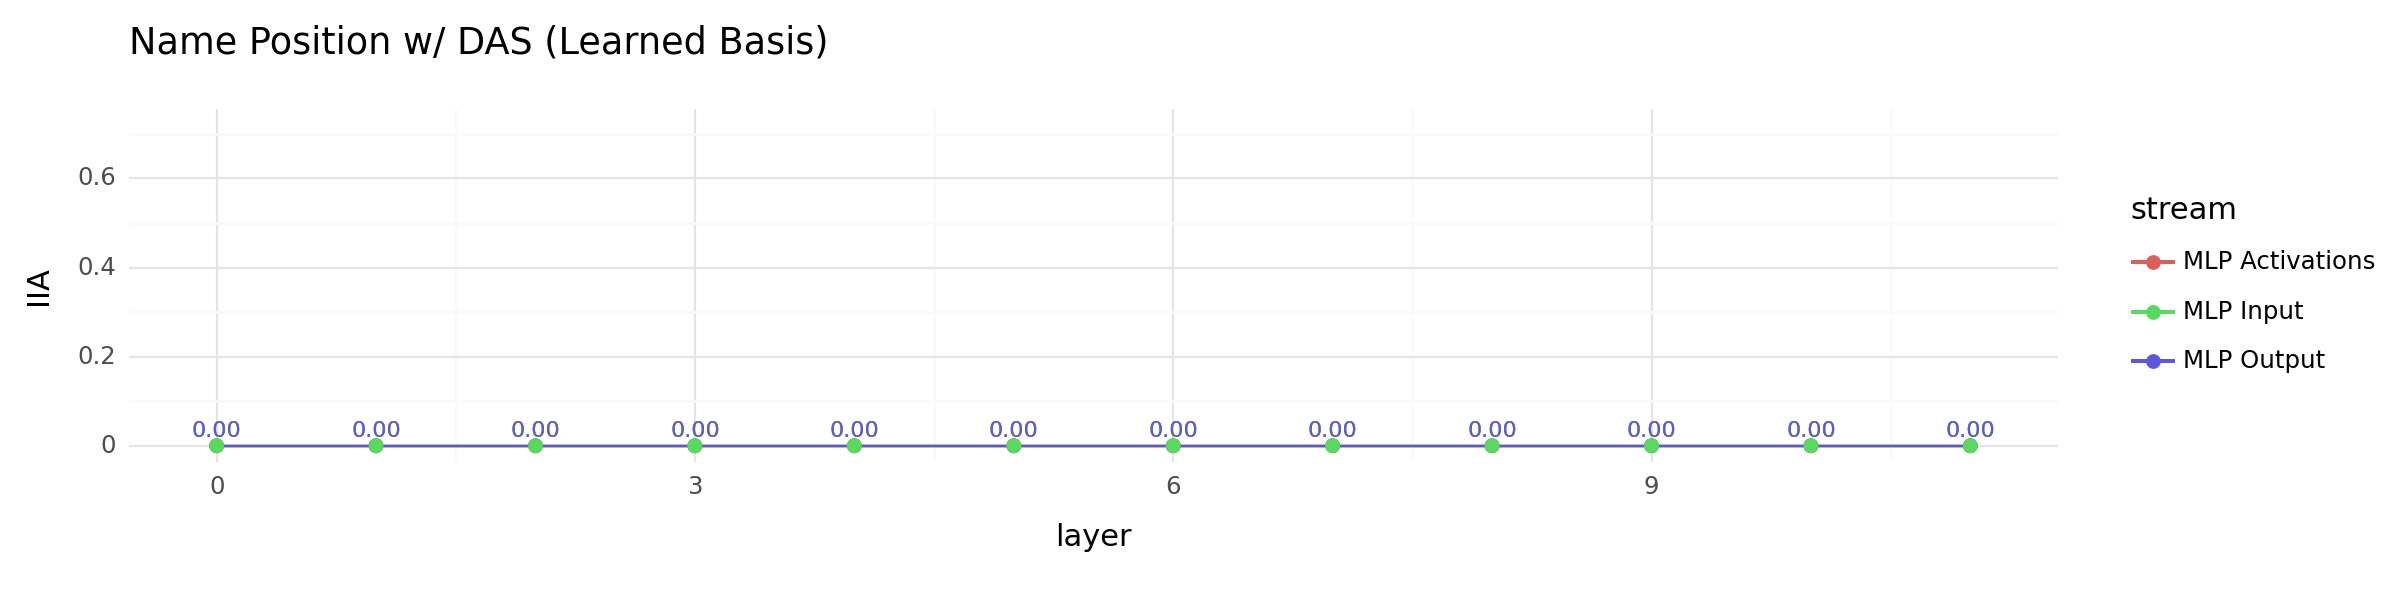

<Figure Size: (1200 x 300)>

In [15]:
# all_streams_df = pd.DataFrame(
#     block_output_data+attn_out_data+
#     mlp_out_data+attn_value_out_data+
#     mlp_act_data+mlp_input_data+
#     block_input_data+attn_input_data
# )
# all_streams_df.to_csv("./tutorial_data/all_streams_df.csv")
all_streams_io_name_df = pd.read_csv("./tutorial_data/all_streams_io_name_df.csv")
all_streams_io_name_df["IIA"] = all_streams_io_name_df["acc"]
df = all_streams_io_name_df[
    all_streams_io_name_df["stream"].isin({"mlp_output", "mlp_input", "mlp_activation"})
].copy()
stream_labels = {
    "mlp_output": "MLP Output",
    "mlp_input": "MLP Input",
    "mlp_activation": "MLP Activations",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
all_mlp_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Name Position w/ DAS (Learned Basis)")
)

ggsave(
    all_mlp_locations_plot,
    filename="./tutorial_data/DAS_IO_name_all_mlp_locations_plot.pdf",
    dpi=200,
)
all_mlp_locations_plot

### Head's Query Representations to Trace Name Mover Head
To use the name position information to copy the IO name, responsible heads need to take in name position information, and process it.

In [ ]:
layer = 9
head_query_output_mo_data = []
for i in range(12):
    _head_query_output_mo_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_query_output",
        heads=sorted(list(set([i for i in range(12)]) - {i})),
        debug=True,
    )[0]
    _head_query_output_mo_data["mo_head"] = i
    head_query_output_mo_data.append(_head_query_output_mo_data)

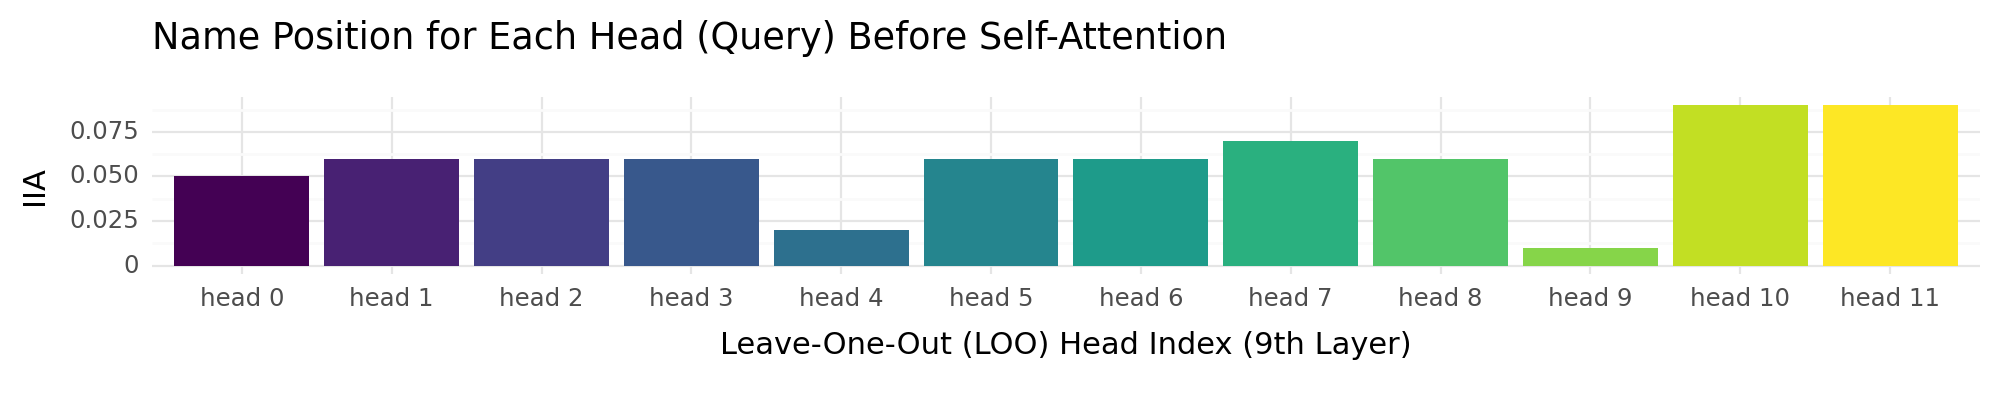

<Figure Size: (1000 x 200)>

In [22]:
layer = 9
# df = pd.DataFrame(head_query_output_mo_data)
# df.to_csv(f"./tutorial_data/layer_{layer}_head_query_output_mo_data.csv")
df = pd.read_csv(f"./tutorial_data/layer_{layer}_head_query_output_mo_data.csv")
df["mo_head_cat"] = pd.Categorical(
    df["mo_head"], categories=df["mo_head"].unique(), ordered=True
)
head_query_output_mo_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Leave-One-Out (LOO) Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"head {i}" for i in df["mo_head"]])
    + ggtitle("Name Position for Each Head (Query) Before Self-Attention")
)

ggsave(
    head_query_output_mo_plot,
    filename=f"./tutorial_data/layer_{layer}_head_query_output_mo_plot.pdf",
    dpi=200,
)
head_query_output_mo_plot

In [ ]:
head_attention_value_output_mo_data = []
for i in range(12):
    _head_attention_value_output_mo_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_attention_value_output",
        heads=sorted(list(set([i for i in range(12)]) - {i})),
        low_rank_dimension=20,
        aligning_variable="name",
        debug=True,
    )[0]
    _head_attention_value_output_mo_data["mo_head"] = i
    head_attention_value_output_mo_data.append(_head_attention_value_output_mo_data)

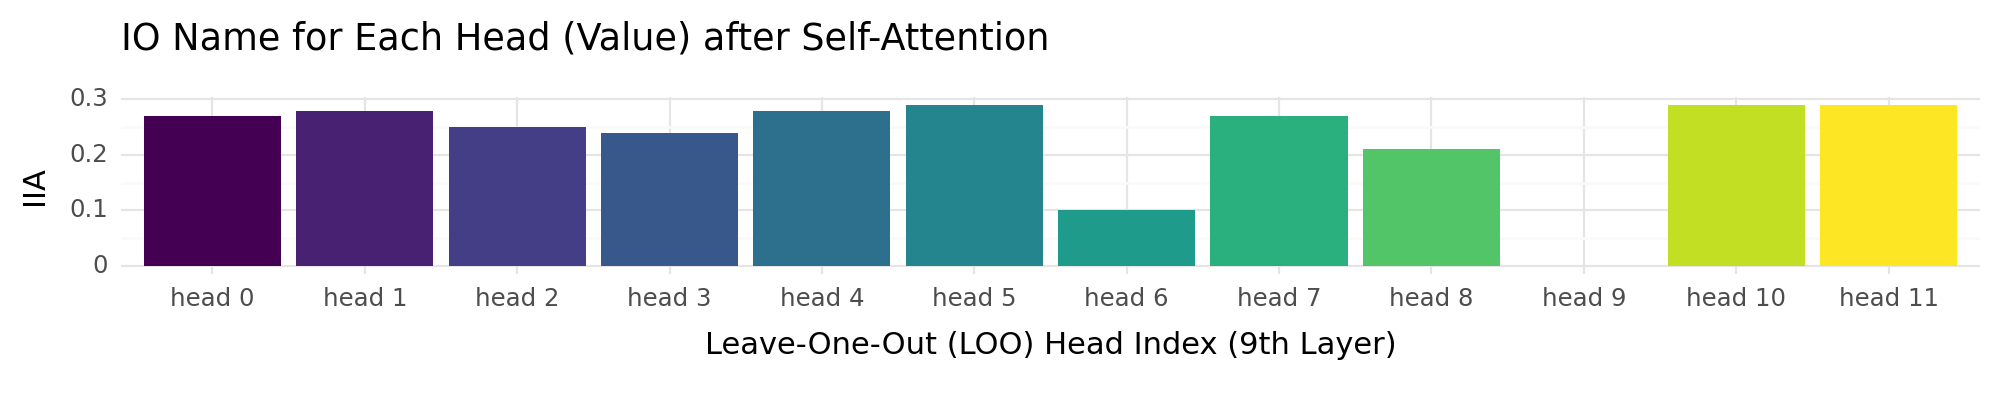

<Figure Size: (1000 x 200)>

In [23]:
# df = pd.DataFrame(head_attention_value_output_mo_data)
# df.to_csv(f"./tutorial_data/layer_{layer}_head_attention_value_output_mo_data.csv")
df = pd.read_csv(
    f"./tutorial_data/layer_{layer}_head_attention_value_output_mo_data.csv"
)
df["mo_head_cat"] = pd.Categorical(
    df["mo_head"], categories=df["mo_head"].unique(), ordered=True
)
head_attention_value_output_mo_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Leave-One-Out (LOO) Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"head {i}" for i in df["mo_head"]])
    + ggtitle("IO Name for Each Head (Value) after Self-Attention")
)

ggsave(
    head_attention_value_output_mo_plot,
    filename=f"./tutorial_data/layer_{layer}_head_attention_value_output_mo_plot.pdf",
    dpi=200,
)
head_attention_value_output_mo_plot

In [ ]:
head_attn_value_out_cumulative_data = []
current_heads = []
for i in [9, 6, 8, 3, 2, 7, 0, 1, 4, 11, 5, 10]:
    current_heads += [i]
    print("evaluating grouped IIA adding head", i)
    _head_attn_value_out_cumulative_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_attention_value_output",
        heads=sorted(current_heads),
        low_rank_dimension=20,
        aligning_variable="name",
        debug=True,
    )[0]
    _head_attn_value_out_cumulative_data["adding_head"] = i
    head_attn_value_out_cumulative_data += [_head_attn_value_out_cumulative_data]

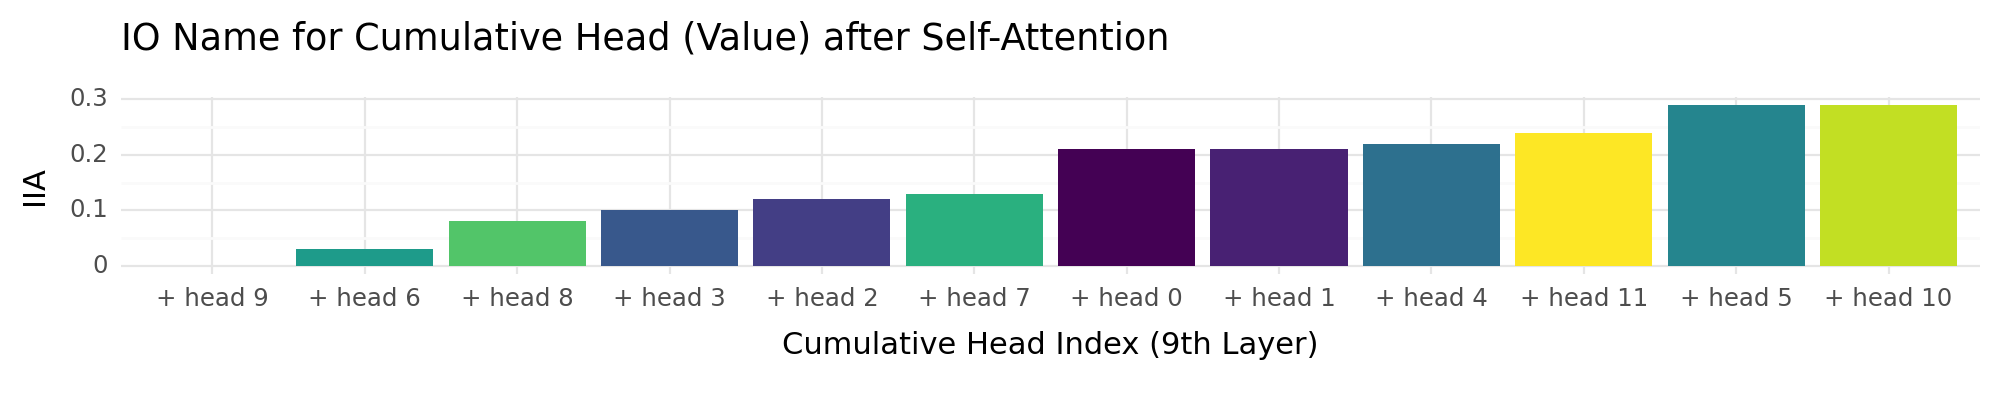

<Figure Size: (1000 x 200)>

In [24]:
# df = pd.DataFrame(head_attn_value_out_cumulative_data)
# df.to_csv(f"./tutorial_data/DAS_IO_layer_{layer}_head_attn_value_out_cumulative_data.csv")
df = pd.read_csv(
    f"./tutorial_data/DAS_IO_layer_{layer}_head_attn_value_out_cumulative_data.csv"
)

df["adding_head_cat"] = pd.Categorical(
    df["adding_head"], categories=df["adding_head"].unique(), ordered=True
)

head_acc_plot = (
    ggplot(df, aes(x="adding_head_cat", y="acc", fill="adding_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Cumulative Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"+ head {i}" for i in df["adding_head"]])
    + ggtitle("IO Name for Cumulative Head (Value) after Self-Attention")
)

ggsave(
    head_acc_plot,
    filename=f"./tutorial_data/DAS_IO_layer_{layer}_head_attn_value_out_cumulative_plot.pdf",
    dpi=200,
)
head_acc_plot

In [ ]:
layer = 10
head_query_output_mo_data = []
for i in range(12):
    _head_query_output_mo_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_query_output",
        heads=sorted(list(set([i for i in range(12)]) - {i})),
        debug=True,
    )[0]
    _head_query_output_mo_data["mo_head"] = i
    head_query_output_mo_data.append(_head_query_output_mo_data)

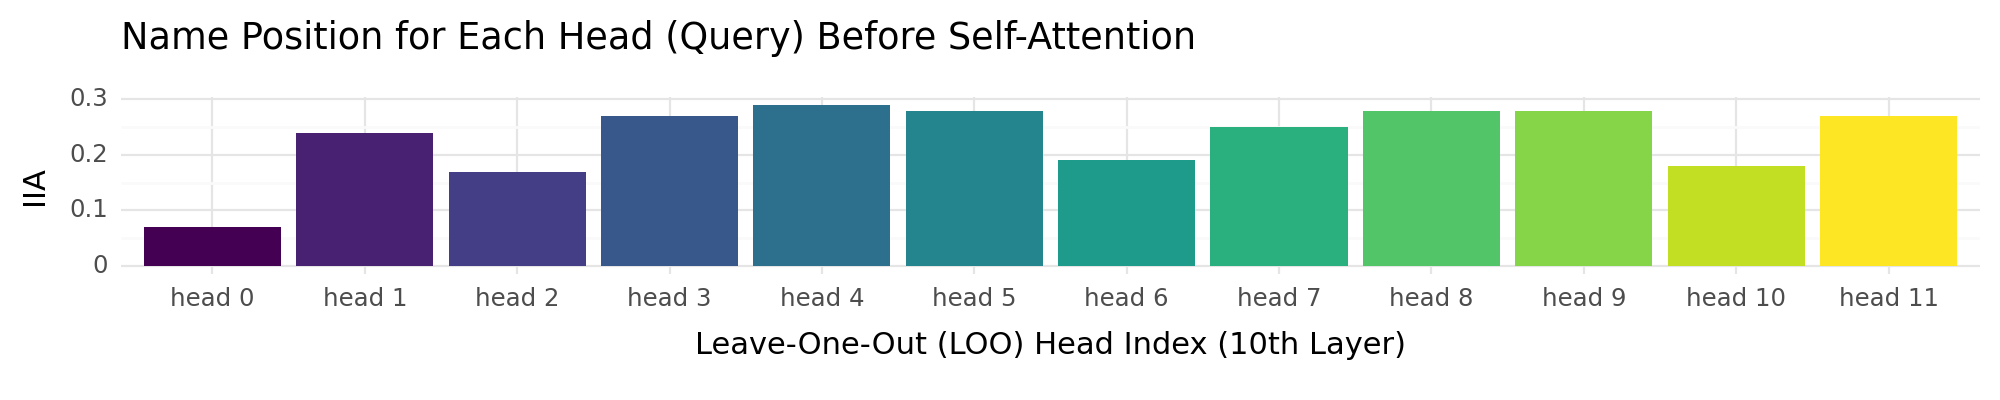

<Figure Size: (1000 x 200)>

In [25]:
layer = 10
# df = pd.DataFrame(head_query_output_mo_data)
# df.to_csv(f"./tutorial_data/layer_{layer}_head_query_output_mo_data.csv")
df = pd.read_csv(f"./tutorial_data/layer_{layer}_head_query_output_mo_data.csv")
df["mo_head_cat"] = pd.Categorical(
    df["mo_head"], categories=df["mo_head"].unique(), ordered=True
)
head_query_output_mo_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Leave-One-Out (LOO) Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"head {i}" for i in df["mo_head"]])
    + ggtitle("Name Position for Each Head (Query) Before Self-Attention")
)

ggsave(
    head_query_output_mo_plot,
    filename=f"./tutorial_data/layer_{layer}_head_query_output_mo_plot.pdf",
    dpi=200,
)
head_query_output_mo_plot

In [ ]:
head_attention_value_output_mo_data = []
for i in range(12):
    _head_attention_value_output_mo_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_attention_value_output",
        heads=sorted(list(set([i for i in range(12)]) - {i})),
        low_rank_dimension=20,
        aligning_variable="name",
        debug=True,
    )[0]
    _head_attention_value_output_mo_data["mo_head"] = i
    head_attention_value_output_mo_data.append(_head_attention_value_output_mo_data)

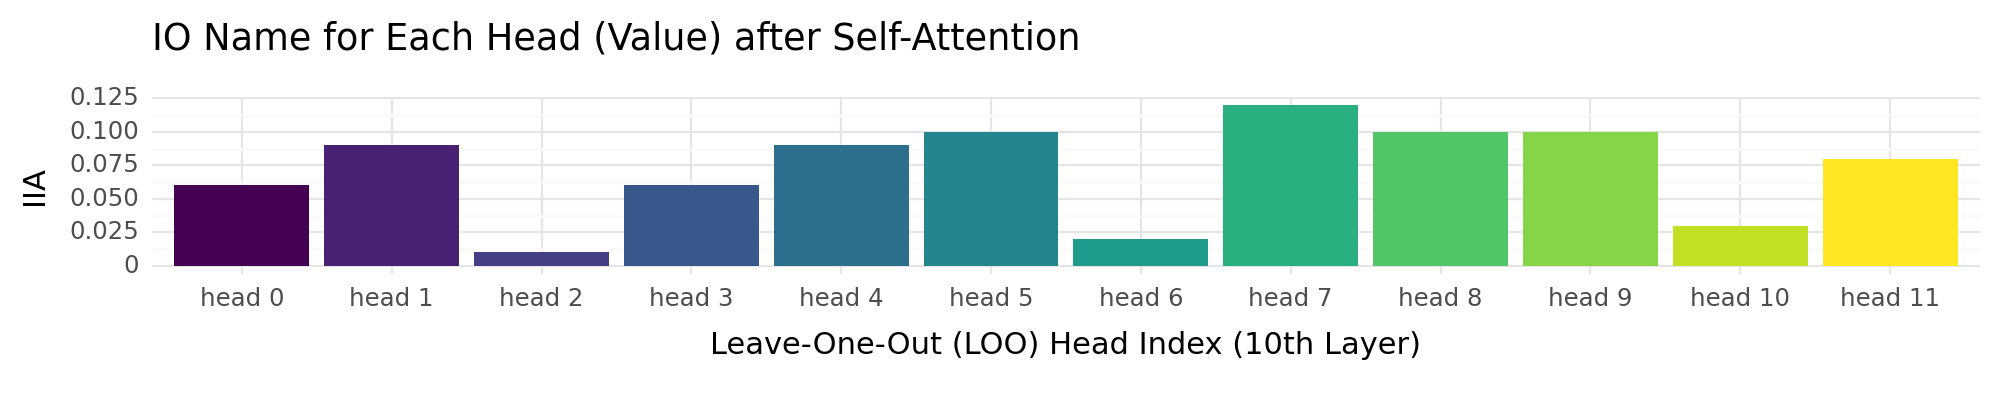

<Figure Size: (1000 x 200)>

In [26]:
# df = pd.DataFrame(head_attention_value_output_mo_data)
# df.to_csv(f"./tutorial_data/layer_{layer}_head_attention_value_output_mo_data.csv")
df = pd.read_csv(
    f"./tutorial_data/layer_{layer}_head_attention_value_output_mo_data.csv"
)
df["mo_head_cat"] = pd.Categorical(
    df["mo_head"], categories=df["mo_head"].unique(), ordered=True
)
head_attention_value_output_mo_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Leave-One-Out (LOO) Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"head {i}" for i in df["mo_head"]])
    + ggtitle("IO Name for Each Head (Value) after Self-Attention")
)

ggsave(
    head_attention_value_output_mo_plot,
    filename=f"./tutorial_data/layer_{layer}_head_attention_value_output_mo_plot.pdf",
    dpi=200,
)
head_attention_value_output_mo_plot

In [ ]:
head_attn_value_out_cumulative_data = []
current_heads = []
for i in [2, 6, 10, 3, 0, 11, 4, 1, 8, 9, 5, 7]:
    current_heads += [i]
    print("evaluating grouped IIA adding head", i)
    _head_attn_value_out_cumulative_data = find_variable_at(
        gpt2,
        tokenizer,
        [17],
        [layer],
        "head_attention_value_output",
        heads=sorted(current_heads),
        low_rank_dimension=20,
        aligning_variable="name",
        debug=True,
    )[0]
    _head_attn_value_out_cumulative_data["adding_head"] = i
    head_attn_value_out_cumulative_data += [_head_attn_value_out_cumulative_data]

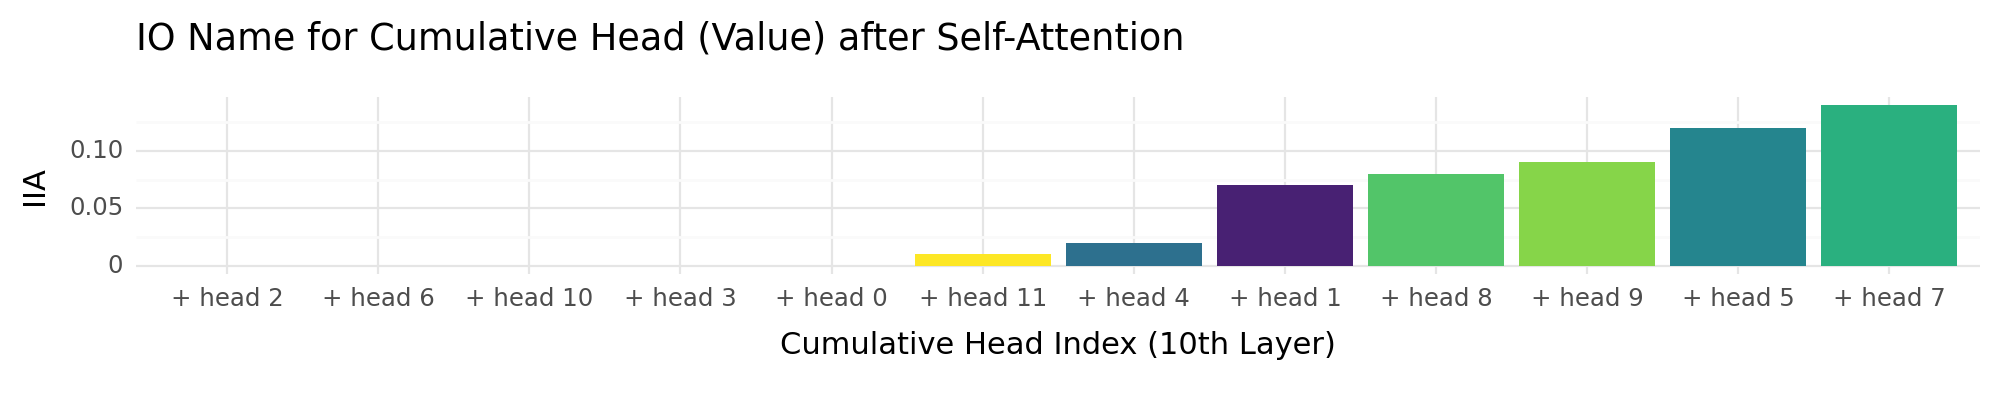

<Figure Size: (1000 x 200)>

In [27]:
# df = pd.DataFrame(head_attn_value_out_cumulative_data)
# df.to_csv(f"./tutorial_data/DAS_IO_layer_{layer}_head_attn_value_out_cumulative_data.csv")
df = pd.read_csv(
    f"./tutorial_data/DAS_IO_layer_{layer}_head_attn_value_out_cumulative_data.csv"
)
df["adding_head_cat"] = pd.Categorical(
    df["adding_head"], categories=df["adding_head"].unique(), ordered=True
)
head_acc_plot = (
    ggplot(df, aes(x="adding_head_cat", y="acc", fill="adding_head"))
    + geom_bar(stat="identity", position="dodge", width=0.9)
    + labs(x=f"Cumulative Head Index ({layer}th Layer)", y="IIA")
    + theme_minimal()  # Add axis labels
    + theme(figure_size=(10, 2))  # Use a minimal theme
    + theme(legend_position="none")
    + scale_x_discrete(labels=[f"+ head {i}" for i in df["adding_head"]])
    + ggtitle("IO Name for Cumulative Head (Value) after Self-Attention")
)

ggsave(
    head_acc_plot,
    filename=f"./tutorial_data/DAS_IO_layer_{layer}_head_attn_value_out_cumulative_plot.pdf",
    dpi=200,
)
head_acc_plot

### Use Boundless DAS to find information
Instead of starting with a fixed number of DAS dimension, we can also use Boundless DAS (Wu et. al., 2023) to dynamically find a good dimension by learning the boundary. Here, we use Boundless DAS to find alignments for the name position information variable as well as the correct IO name variable. Very similar results, yet alignments with the IO name seems to be consistently better.

In [ ]:
attn_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_input",
    aligning_variable="position",  # now we are localizing the IO name
    do_boundless_das=True,
    debug=True,
)
block_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_input",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)
mlp_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_input",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)
mlp_act_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_activation",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)
attn_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_output",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)
mlp_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_output",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)
attn_value_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_value_output",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)
block_output_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_output",
    aligning_variable="position",
    do_boundless_das=True,
    debug=True,
)

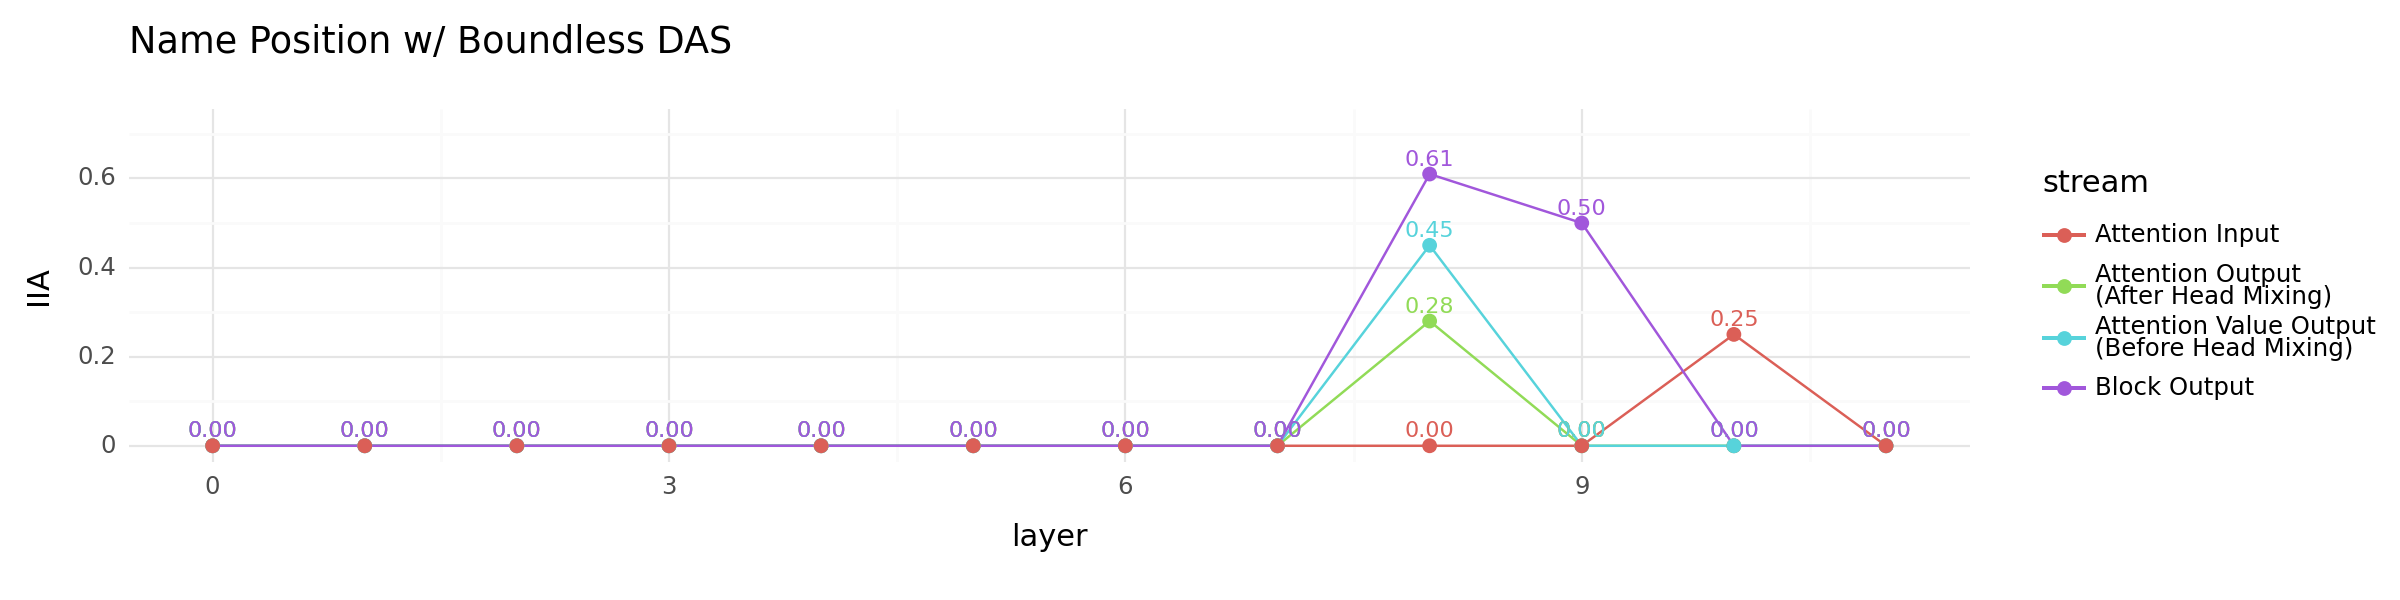

<Figure Size: (1200 x 300)>

In [22]:
# all_streams_io_name_df = pd.DataFrame(
#     block_output_data+
#     attn_out_data+mlp_out_data+
#     attn_value_out_data+mlp_act_data+
#     mlp_input_data+block_input_data+attn_input_data
# )
# all_streams_io_name_df.to_csv("./tutorial_data/all_streams_boundless_das_df.csv")
all_streams_df = pd.read_csv("./tutorial_data/all_streams_boundless_das_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin(
        {
            "block_output",
            "attention_input",
            "attention_output",
            "attention_value_output",
        }
    )
].copy()
stream_labels = {
    "block_output": "Block Output",
    "attention_input": "Attention Input",
    "attention_output": "Attention Output\n(After Head Mixing)",
    "attention_value_output": "Attention Value Output\n(Before Head Mixing)",
}
df.loc[:, "stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df.loc[:, "IIA_formatted"] = df["IIA"].map(custom_format)
other_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Name Position w/ Boundless DAS")
)

ggsave(
    other_locations_plot,
    filename="./tutorial_data/Boundless_DAS_other_locations_plot.pdf",
    dpi=200,
)
other_locations_plot

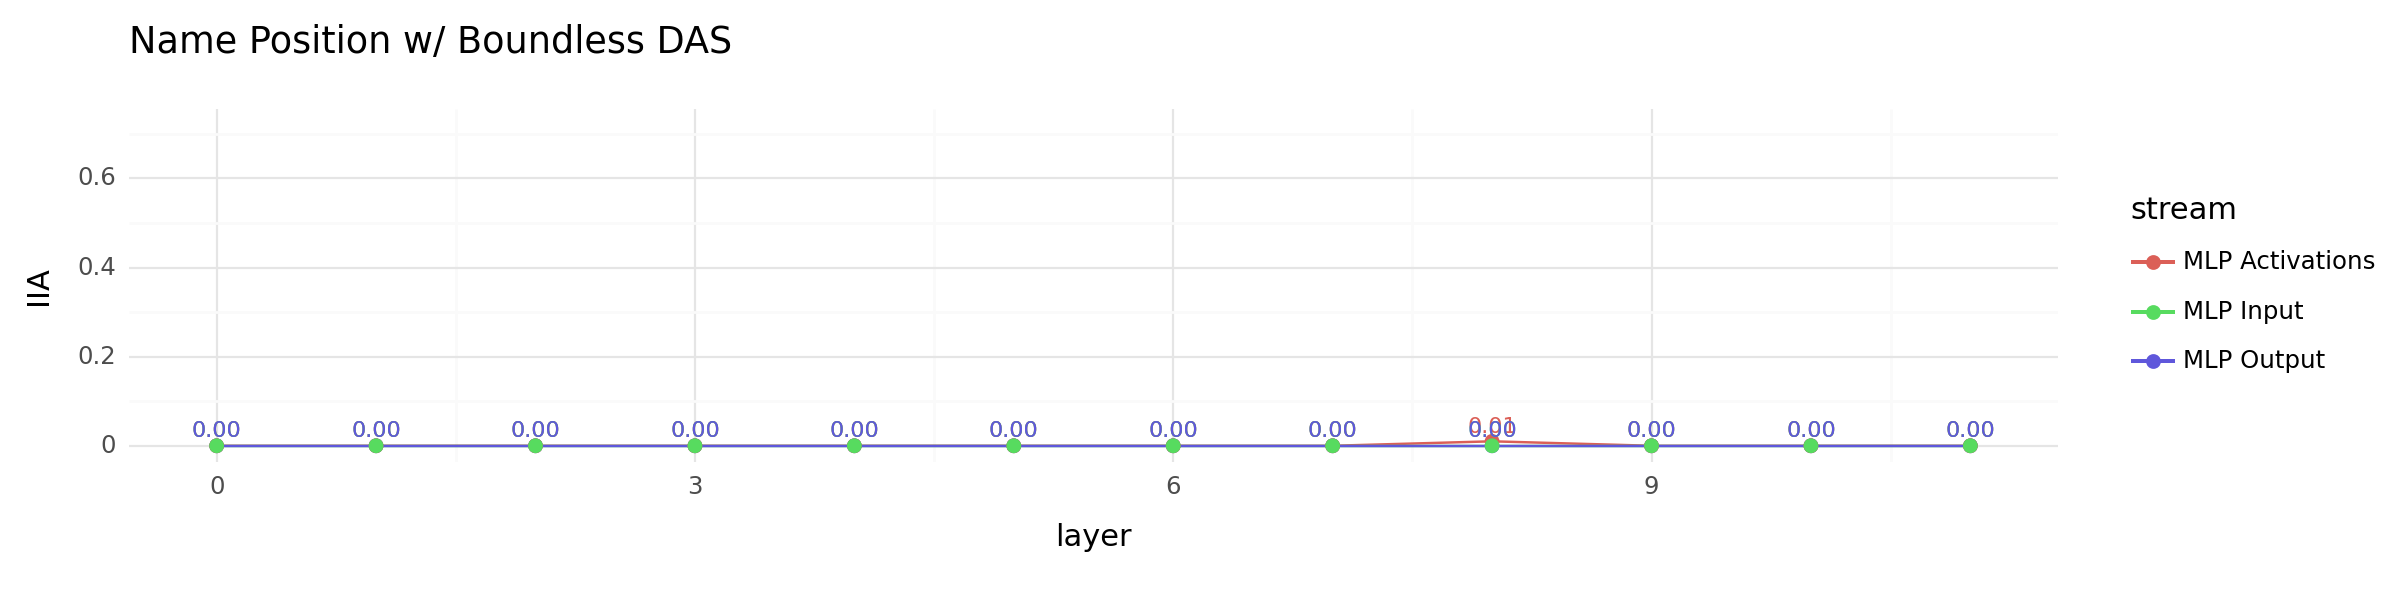

<Figure Size: (1200 x 300)>

In [25]:
all_streams_df = pd.read_csv("./tutorial_data/all_streams_boundless_das_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin({"mlp_output", "mlp_input", "mlp_activation"})
].copy()
stream_labels = {
    "mlp_output": "MLP Output",
    "mlp_input": "MLP Input",
    "mlp_activation": "MLP Activations",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
all_mlp_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Name Position w/ Boundless DAS")
)

ggsave(
    all_mlp_locations_plot,
    filename="./tutorial_data/Boundless_DAS_all_mlp_locations_plot.pdf",
    dpi=200,
)
all_mlp_locations_plot

In [ ]:
attn_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_input",
    aligning_variable="name",  # now we are localizing the IO name
    do_boundless_das=True,
    debug=True,
)
block_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_input",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)
mlp_input_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_input",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)
mlp_act_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_activation",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)
attn_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_output",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)
mlp_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "mlp_output",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)
attn_value_out_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "attention_value_output",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)
block_output_data = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [i for i in range(12)],
    "block_output",
    aligning_variable="name",
    do_boundless_das=True,
    debug=True,
)

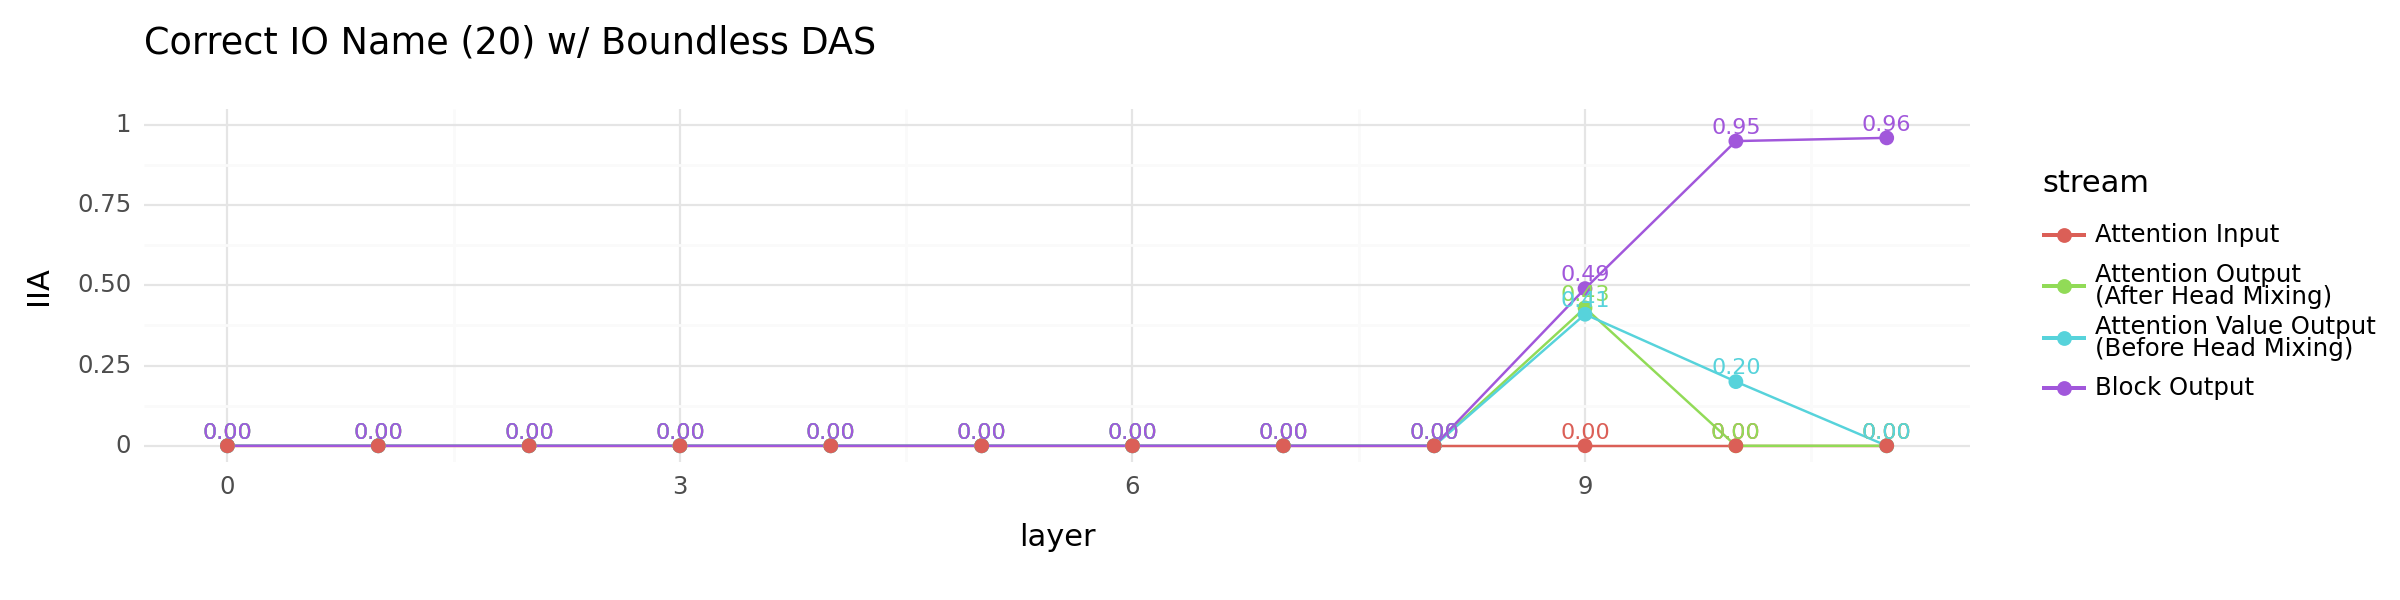

<Figure Size: (1200 x 300)>

In [27]:
# all_streams_io_name_df = pd.DataFrame(
#     block_output_data+
#     attn_out_data+mlp_out_data+
#     attn_value_out_data+mlp_act_data+
#     mlp_input_data+block_input_data+attn_input_data
# )
# all_streams_io_name_df.to_csv("./tutorial_data/all_streams_io_name_boundless_das_df.csv")
all_streams_df = pd.read_csv("./tutorial_data/all_streams_io_name_boundless_das_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin(
        {
            "block_output",
            "attention_input",
            "attention_output",
            "attention_value_output",
        }
    )
].copy()
stream_labels = {
    "block_output": "Block Output",
    "attention_input": "Attention Input",
    "attention_output": "Attention Output\n(After Head Mixing)",
    "attention_value_output": "Attention Value Output\n(Before Head Mixing)",
}
df.loc[:, "stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df.loc[:, "IIA_formatted"] = df["IIA"].map(custom_format)
other_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 1)
    + theme(figure_size=(12, 3))
    + ggtitle("Correct IO Name (20) w/ Boundless DAS")
)

ggsave(
    other_locations_plot,
    filename="./tutorial_data/Boundless_DAS_IO_name_other_locations_plot.pdf",
    dpi=200,
)
other_locations_plot

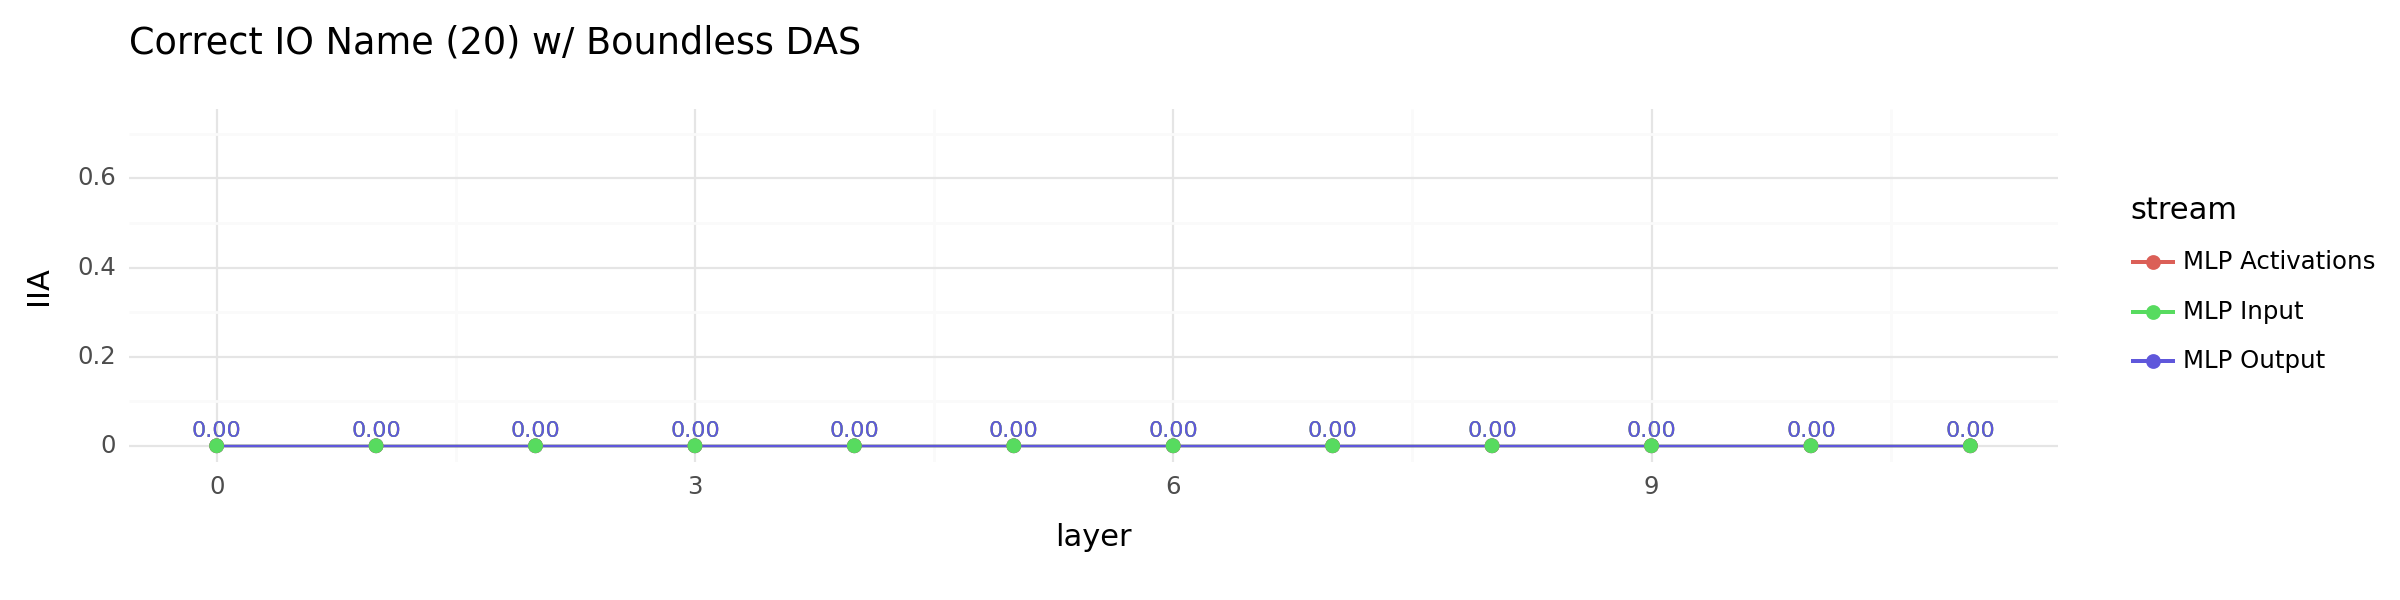

<Figure Size: (1200 x 300)>

In [26]:
all_streams_df = pd.read_csv("./tutorial_data/all_streams_io_name_boundless_das_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[
    all_streams_df["stream"].isin({"mlp_output", "mlp_input", "mlp_activation"})
].copy()
stream_labels = {
    "mlp_output": "MLP Output",
    "mlp_input": "MLP Input",
    "mlp_activation": "MLP Activations",
}
df["stream"] = df["stream"].replace(stream_labels)


def custom_format(x):
    return f"{x:.2f}"


df["IIA_formatted"] = df["IIA"].apply(custom_format)
all_mlp_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream"))
    + geom_line()
    + geom_point(size=2)
    + geom_text(
        aes(label="IIA_formatted"), nudge_y=0.01, size=8, va="bottom", show_legend=False
    )
    + theme_minimal()
    + ylim(0, 0.72)
    + theme(figure_size=(12, 3))
    + ggtitle("Correct IO Name (20) w/ Boundless DAS")
)

ggsave(
    all_mlp_locations_plot,
    filename="./tutorial_data/Boundless_DAS_IO_name_all_mlp_locations_plot.pdf",
    dpi=200,
)
all_mlp_locations_plot

### DAS and Boundless DAS weight matrix and head importance
DAS-based methods learn a subspace that is a linear combination of axes in the original basis. Will the learned linear combination (i.e., the learned weights) interpretable by showing head's importance when applied on top of the attention value output stream before the head mixing? In this section, we investigate this question for both DAS as well as Boundless DAS when aligning with the name position variable as well as the IO name variable.

In [143]:
_, boundless_das_intervenable = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [8],
    "attention_value_output",
    aligning_variable="position",
    do_boundless_das=True,
    return_intervenable=True,
    debug=True,
)

finding name position at: pos->17, layers->8, stream->attention_value_output


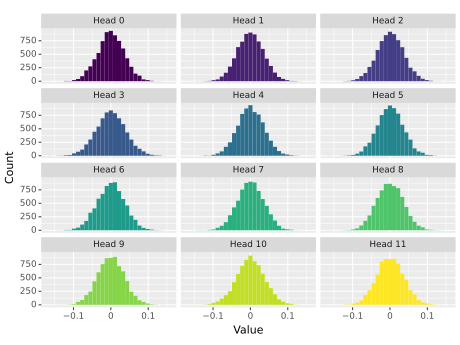

In [144]:
intervention = boundless_das_intervenable.interventions[
    "layer.8.repr.attention_value_output.unit.pos.nunit.1#0"
][0]
boundary_mask = sigmoid_boundary(
    intervention.intervention_population.repeat(1, 1),
    0.0,
    intervention.intervention_boundaries[0] * int(intervention.embed_dim),
    intervention.temperature,
)
learned_weights = (intervention.rotate_layer.weight * boundary_mask)[
    :, : math.ceil(intervention.intervention_boundaries[0] * 768)
]
headwise_learned_weights = torch.chunk(learned_weights, chunks=12, dim=0)

sampled_weights = [w.cpu().data.flatten().numpy() for w in headwise_learned_weights]

# Assuming your_list is your 2D list where each sublist is a NumPy array
df = pd.DataFrame(
    [
        (f"Head {i}", value)
        for i, sublist in enumerate(sampled_weights)
        for value in sublist
    ],
    columns=["Group", "Value"],
)
df["Group"] = pd.Categorical(
    df["Group"], categories=[f"Head {i}" for i in range(12)], ordered=True
)

# Plotting
boundless_das_weight_plot = (
    ggplot(df, aes(x="Value", fill="Group"))
    + geom_histogram(bins=30)
    + facet_wrap("~Group", ncol=3)
    + theme(  # Arrange in a grid with 3 columns
        legend_position="none", subplots_adjust={"wspace": 0.25, "hspace": 0.25}
    )
    + labs(x="Value", y="Count")
)
ggsave(
    boundless_das_weight_plot,
    filename="./tutorial_data/Boundless_DAS_weight_plot.pdf",
    dpi=200,
)
print(boundless_das_weight_plot)

In [145]:
_, das_intervenable = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [8],
    "attention_value_output",
    aligning_variable="position",
    return_intervenable=True,
    debug=True,
)

finding name position at: pos->17, layers->8, stream->attention_value_output


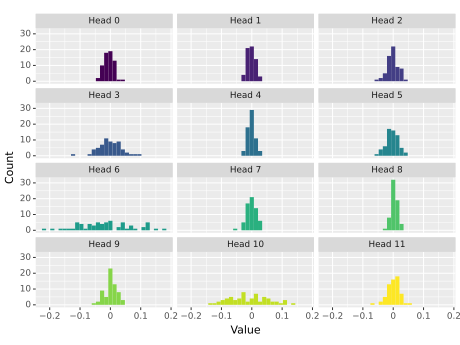

In [146]:
intervention = das_intervenable.interventions[
    "layer.8.repr.attention_value_output.unit.pos.nunit.1#0"
][0]
learned_weights = intervention.rotate_layer.weight
headwise_learned_weights = torch.chunk(learned_weights, chunks=12, dim=0)

sampled_weights = [w.cpu().data.flatten().numpy() for w in headwise_learned_weights]

df = pd.DataFrame(
    [
        (f"Head {i}", value)
        for i, sublist in enumerate(sampled_weights)
        for value in sublist
    ],
    columns=["Group", "Value"],
)
df["Group"] = pd.Categorical(
    df["Group"], categories=[f"Head {i}" for i in range(12)], ordered=True
)

# Plotting
das_weight_plot = (
    ggplot(df, aes(x="Value", fill="Group"))
    + geom_histogram(bins=30)
    + facet_wrap("~Group", ncol=3)
    + theme(  # Arrange in a grid with 3 columns
        legend_position="none", subplots_adjust={"wspace": 0.25, "hspace": 0.25}
    )
    + labs(x="Value", y="Count")
)
ggsave(das_weight_plot, filename="./tutorial_data/DAS_weight_plot.pdf", dpi=200)
print(das_weight_plot)

In [147]:
_, boundless_das_intervenable = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [9],
    "attention_value_output",
    aligning_variable="name",
    do_boundless_das=True,
    return_intervenable=True,
    debug=True,
)

finding name position at: pos->17, layers->9, stream->attention_value_output


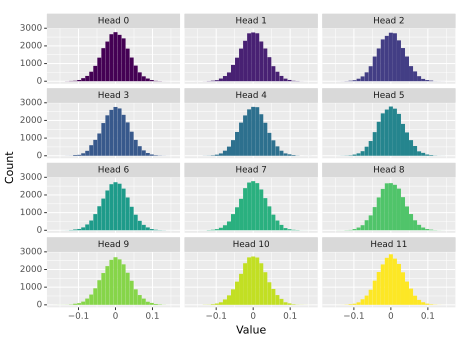

In [148]:
intervention = boundless_das_intervenable.interventions[
    "layer.9.repr.attention_value_output.unit.pos.nunit.1#0"
][0]
boundary_mask = sigmoid_boundary(
    intervention.intervention_population.repeat(1, 1),
    0.0,
    intervention.intervention_boundaries[0] * int(intervention.embed_dim),
    intervention.temperature,
)
learned_weights = (intervention.rotate_layer.weight * boundary_mask)[
    :, : math.ceil(intervention.intervention_boundaries[0] * 768)
]
headwise_learned_weights = torch.chunk(learned_weights, chunks=12, dim=0)

sampled_weights = [w.cpu().data.flatten().numpy() for w in headwise_learned_weights]

# Assuming your_list is your 2D list where each sublist is a NumPy array
df = pd.DataFrame(
    [
        (f"Head {i}", value)
        for i, sublist in enumerate(sampled_weights)
        for value in sublist
    ],
    columns=["Group", "Value"],
)
df["Group"] = pd.Categorical(
    df["Group"], categories=[f"Head {i}" for i in range(12)], ordered=True
)

# Plotting
boundless_das_weight_plot = (
    ggplot(df, aes(x="Value", fill="Group"))
    + geom_histogram(bins=30)
    + facet_wrap("~Group", ncol=3)
    + theme(  # Arrange in a grid with 3 columns
        legend_position="none", subplots_adjust={"wspace": 0.25, "hspace": 0.25}
    )
    + labs(x="Value", y="Count")
)
ggsave(
    boundless_das_weight_plot,
    filename="./tutorial_data/Boundless_DAS_IO_name_weight_plot.pdf",
    dpi=200,
)
print(boundless_das_weight_plot)

In [149]:
_, das_intervenable = find_variable_at(
    gpt2,
    tokenizer,
    [17],
    [9],
    "attention_value_output",
    low_rank_dimension=20,
    aligning_variable="name",
    return_intervenable=True,
    debug=True,
)

finding name position at: pos->17, layers->9, stream->attention_value_output


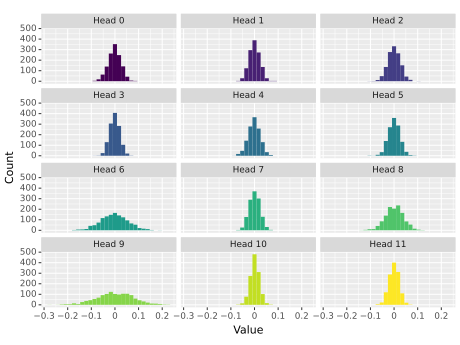

In [150]:
intervention = das_intervenable.interventions[
    "layer.9.repr.attention_value_output.unit.pos.nunit.1#0"
][0]
learned_weights = intervention.rotate_layer.weight
headwise_learned_weights = torch.chunk(learned_weights, chunks=12, dim=0)

sampled_weights = [w.cpu().data.flatten().numpy() for w in headwise_learned_weights]

df = pd.DataFrame(
    [
        (f"Head {i}", value)
        for i, sublist in enumerate(sampled_weights)
        for value in sublist
    ],
    columns=["Group", "Value"],
)
df["Group"] = pd.Categorical(
    df["Group"], categories=[f"Head {i}" for i in range(12)], ordered=True
)

# Plotting
das_weight_plot = (
    ggplot(df, aes(x="Value", fill="Group"))
    + geom_histogram(bins=30)
    + facet_wrap("~Group", ncol=3)
    + theme(  # Arrange in a grid with 3 columns
        legend_position="none", subplots_adjust={"wspace": 0.25, "hspace": 0.25}
    )
    + labs(x="Value", y="Count")
)
ggsave(das_weight_plot, filename="./tutorial_data/DAS_IO_name_weight_plot.pdf", dpi=200)
print(das_weight_plot)

**Findings:** DAS learned weights map very well to head importance! In the plot above, we can see that Heads 6 and 10 have many non-zero entries, indicating that these neurons contribute significantly to aligning with the name position information. Boundless DAS shows a less salient result, suggesting that it learns a more distributed representation.